# Exploración de Imágenes
Se revisa la visualización de las diferentes categorías de hallazgos presentes en las imágenes

## Descripción de Categorías

In [1]:
import ast

import pandas as pd
from Utils import Utils
utils = Utils()

### Categorías de Hallazgos Existentes

In [2]:
findings = utils.findings

finding_categories = findings['finding_categories'].value_counts()
finding_categories

finding_categories
['No Finding']                                                                                      18232
['Mass']                                                                                             1123
['Suspicious Calcification']                                                                          402
['Focal Asymmetry']                                                                                   232
['Architectural Distortion']                                                                           95
['Asymmetry']                                                                                          90
['Suspicious Calcification', 'Mass']                                                                   82
['Suspicious Lymph Node']                                                                              57
['Skin Thickening']                                                                                    38
['Suspicious Calcification'

### Visualización por Categoría

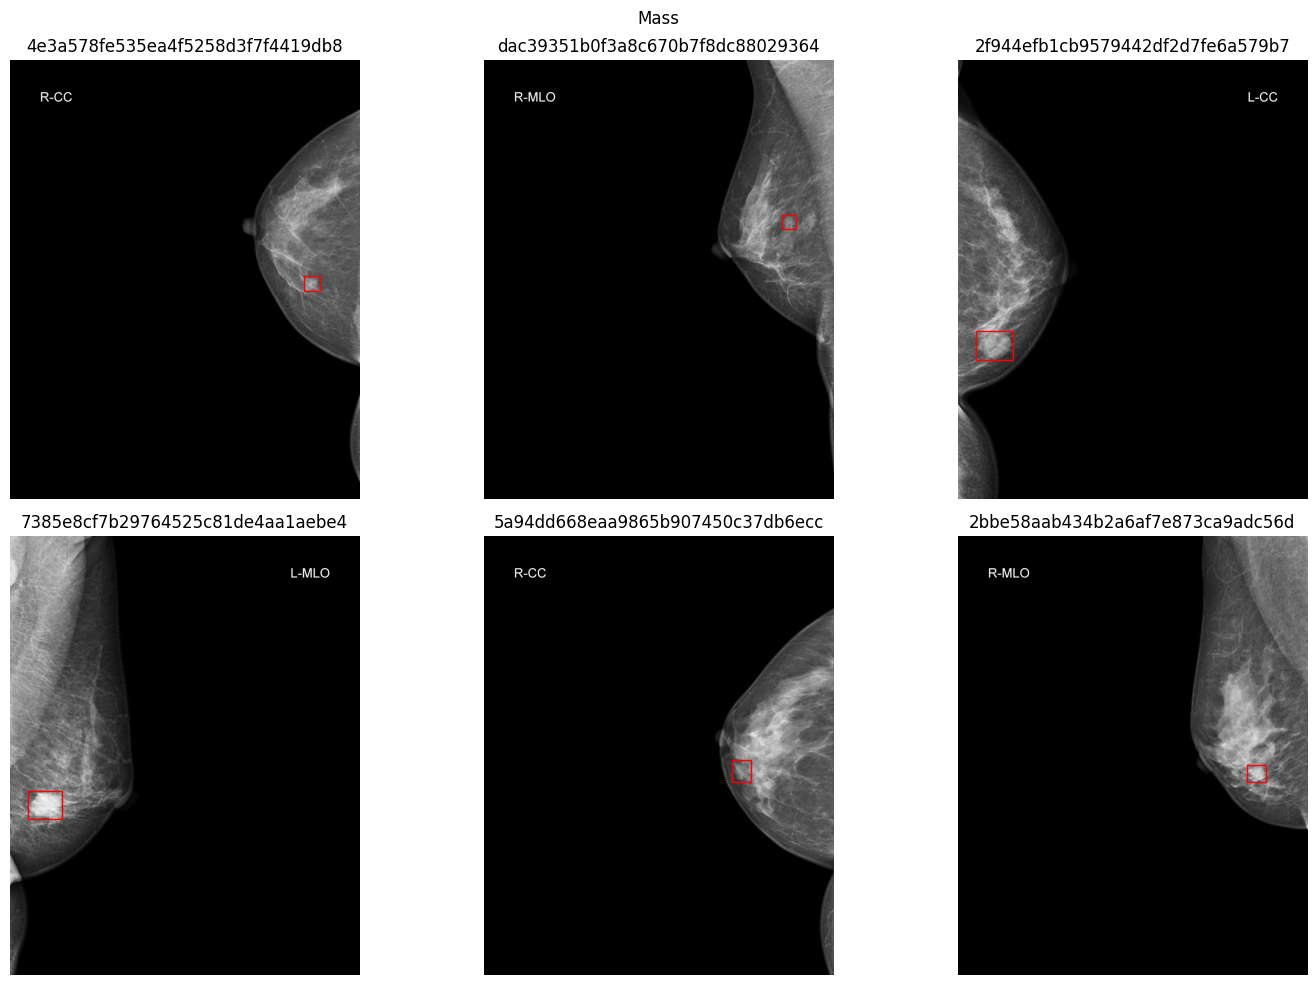

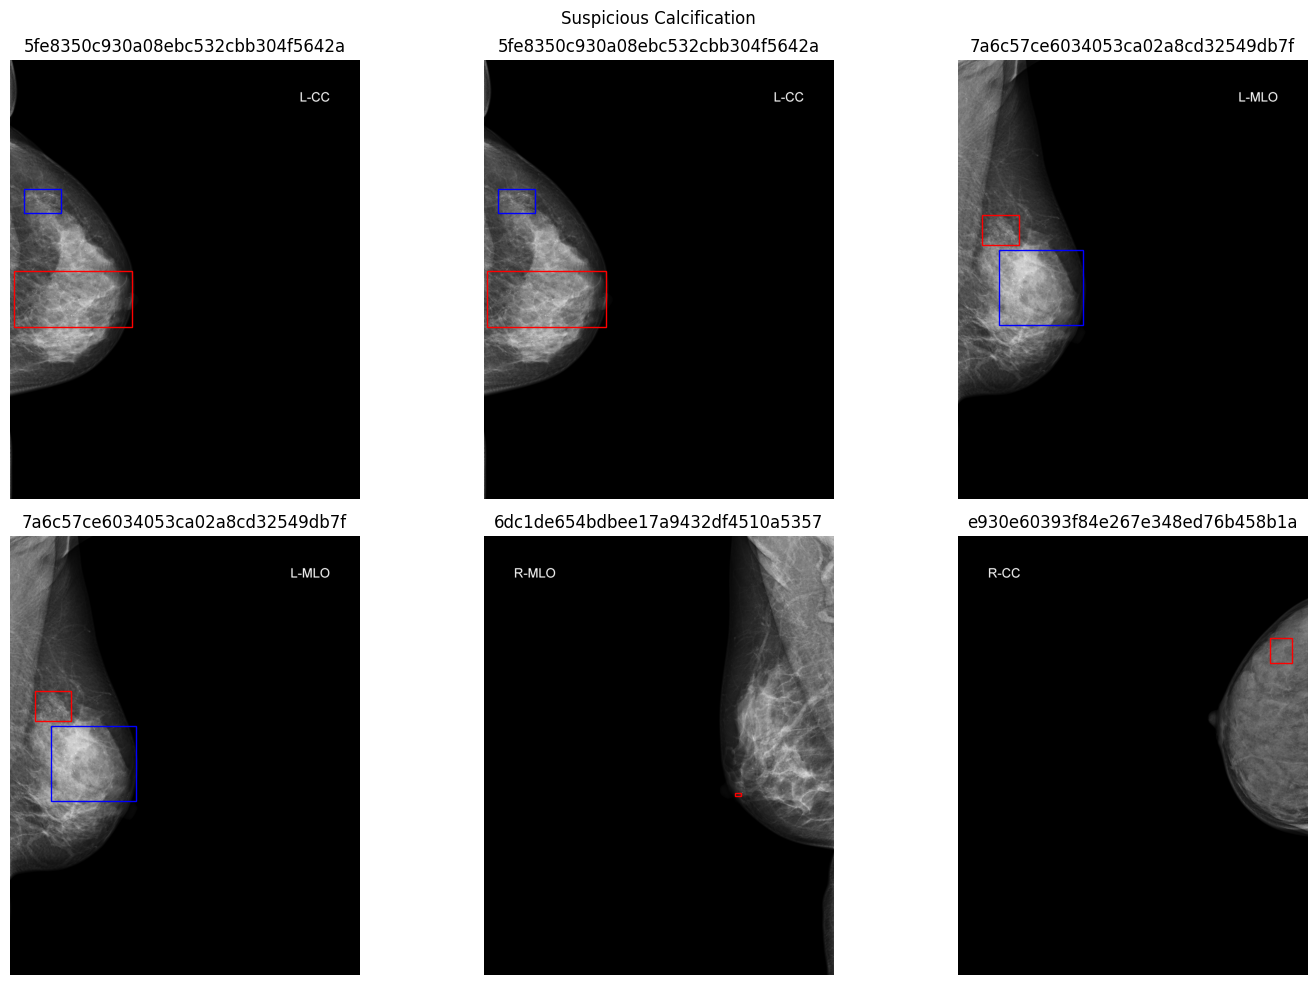

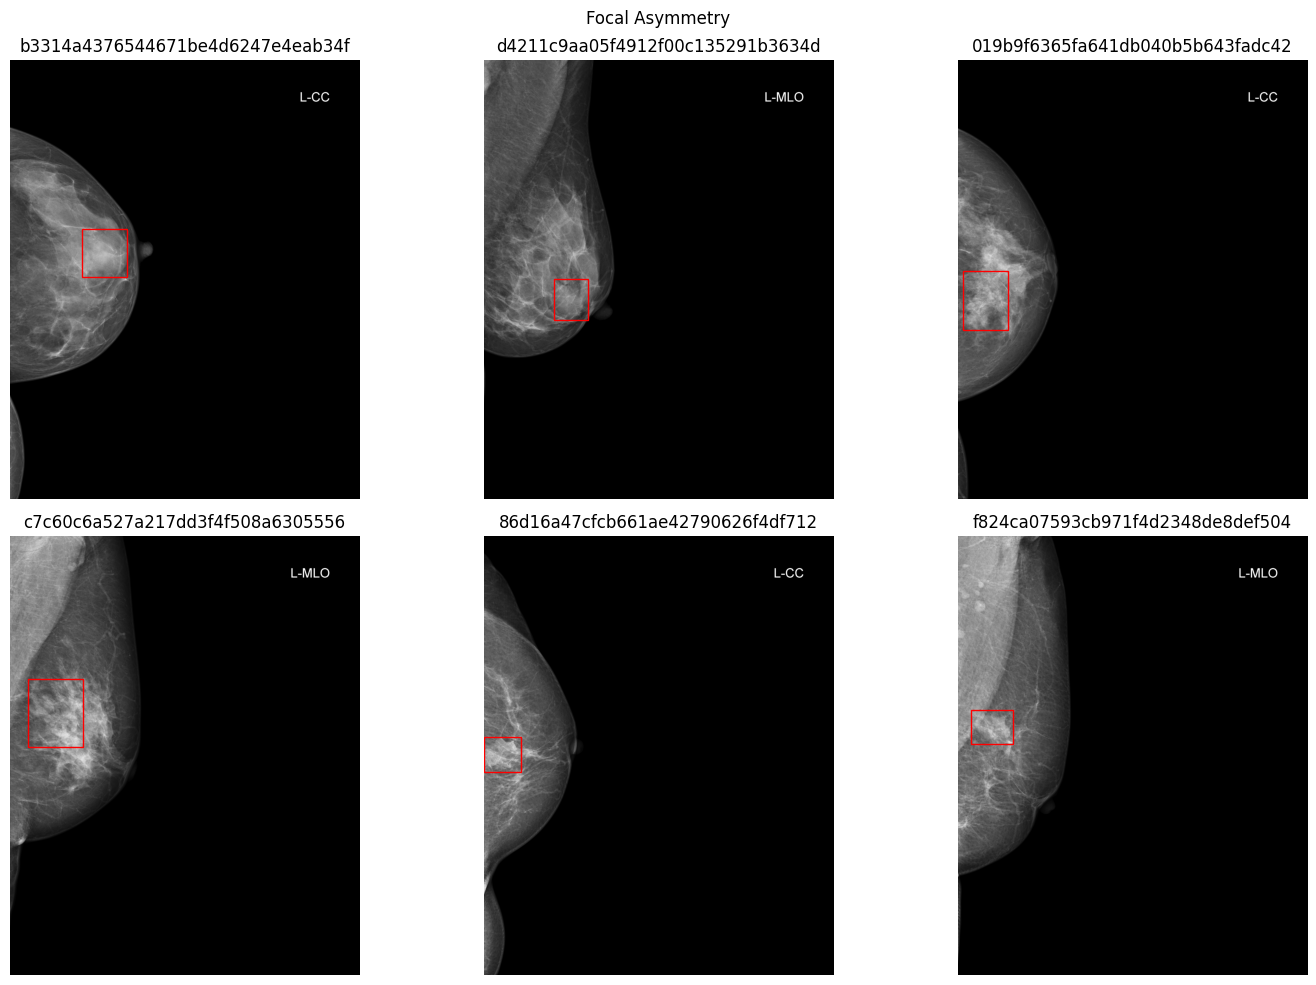

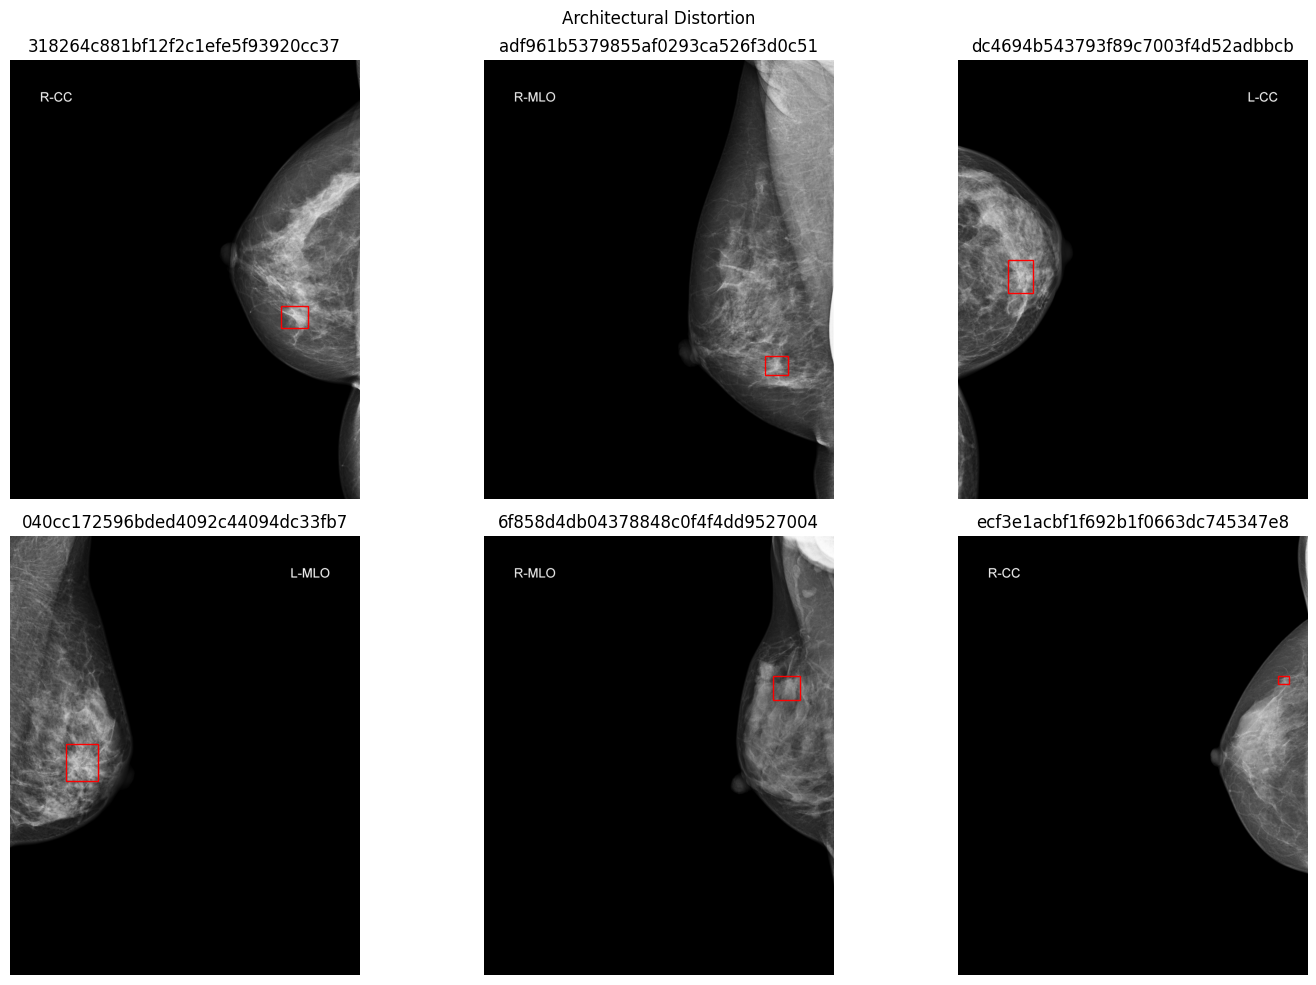

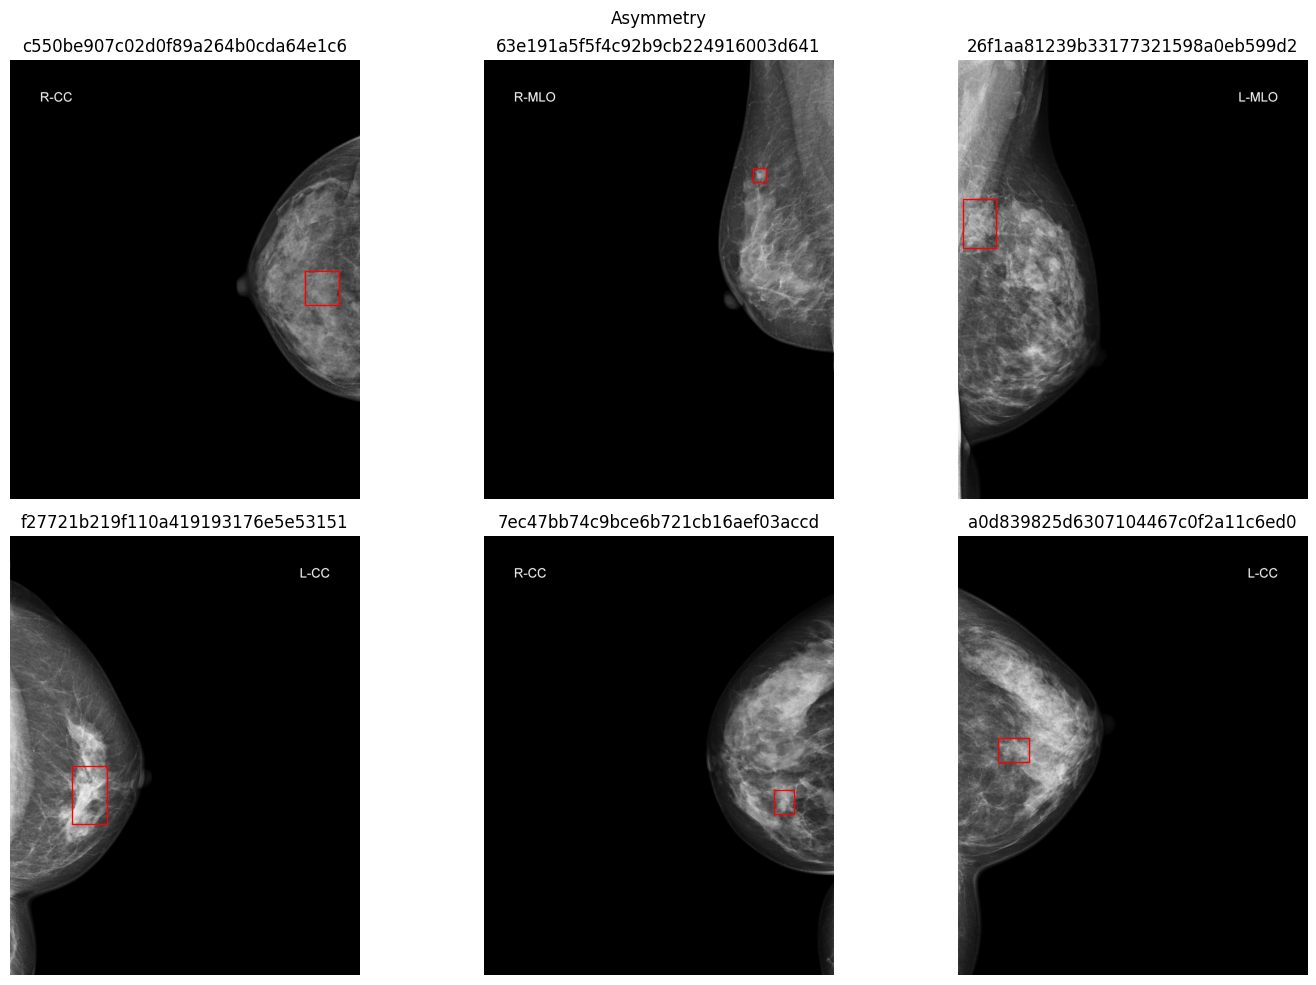

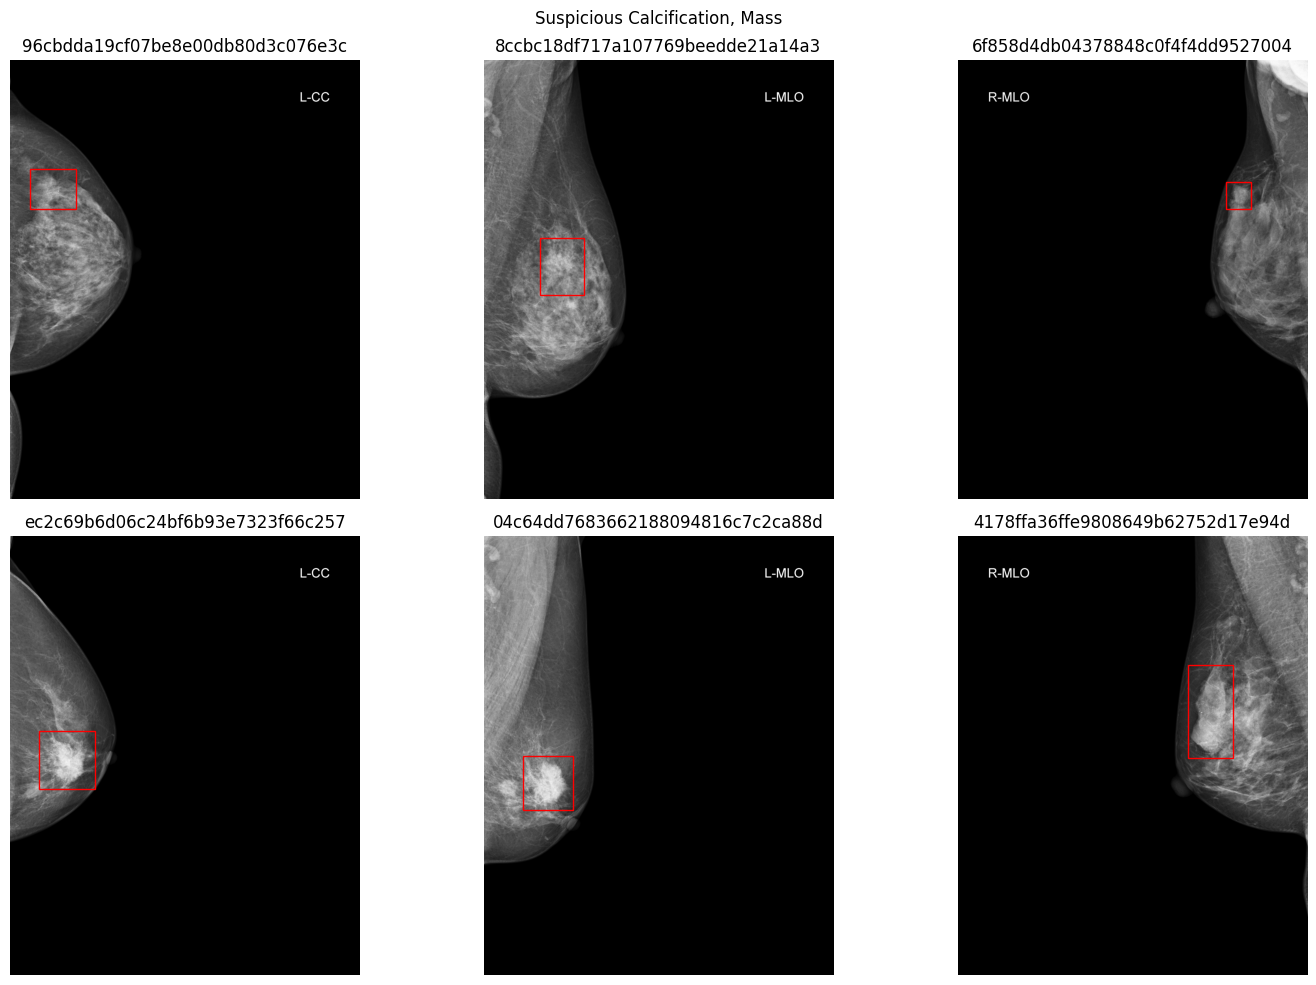

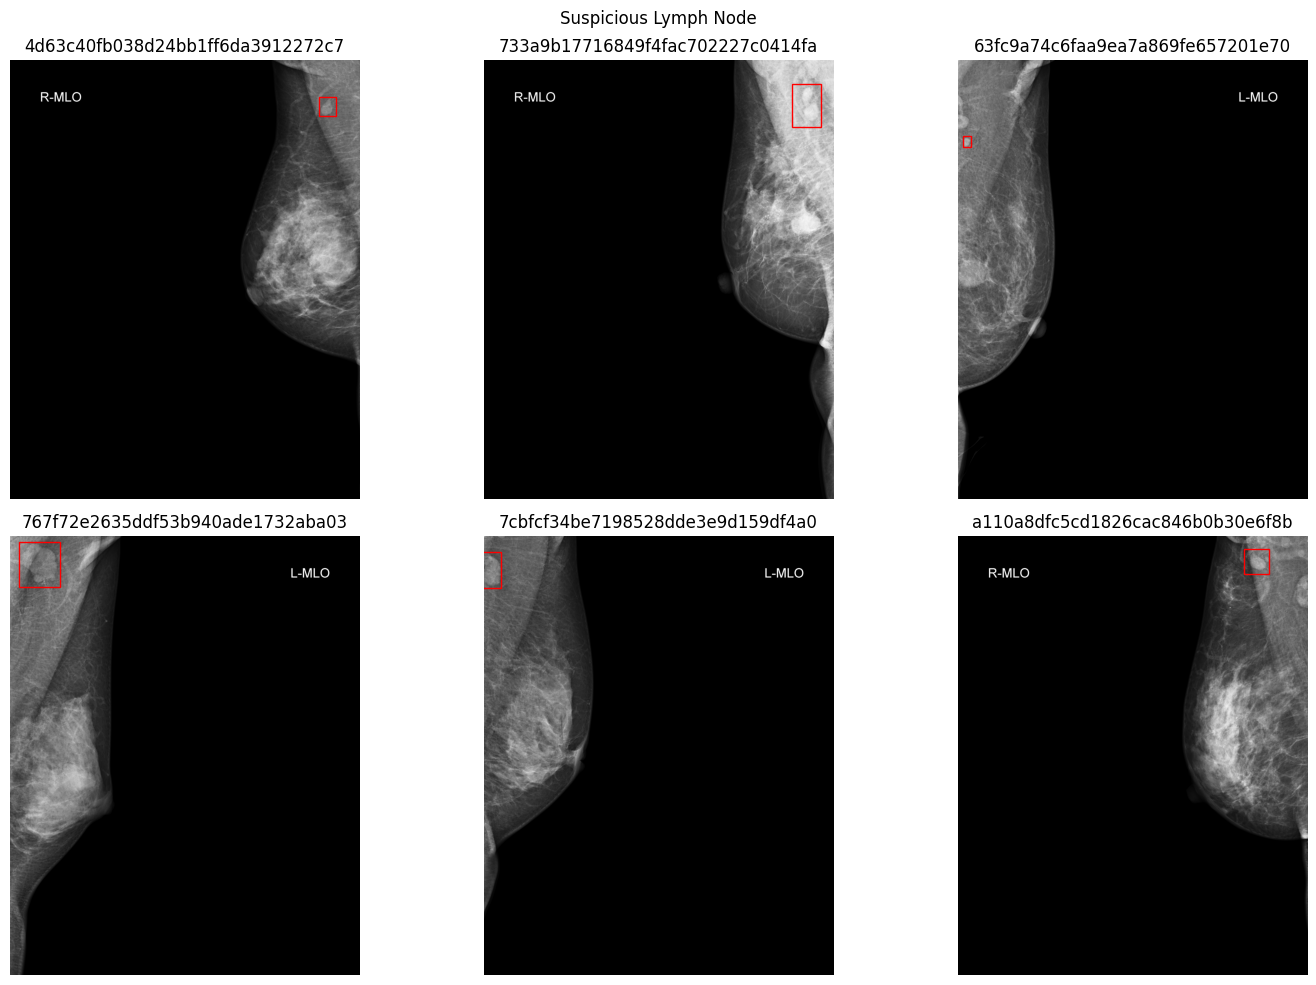

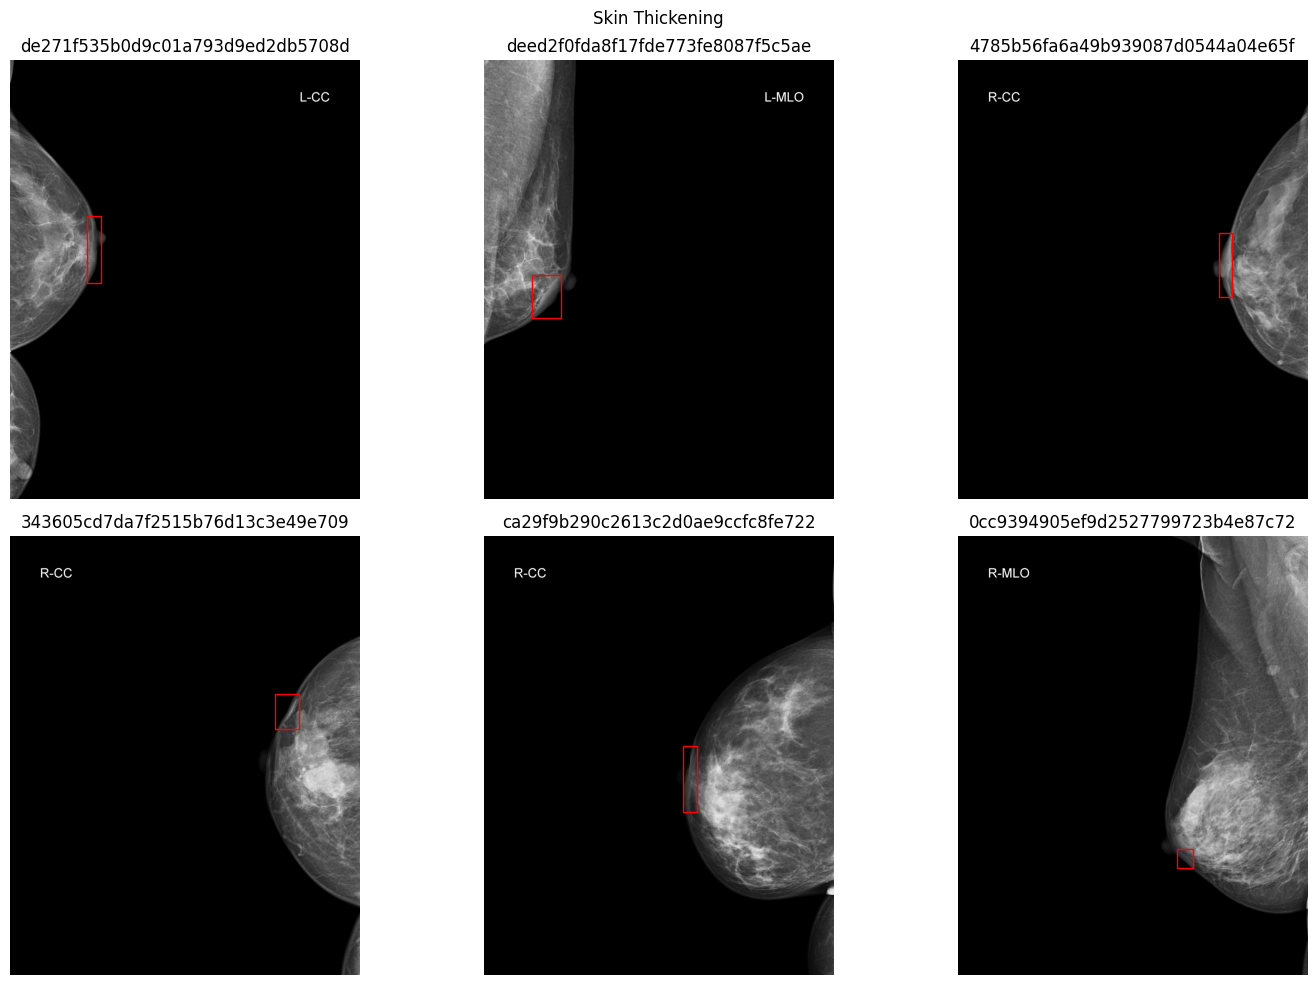

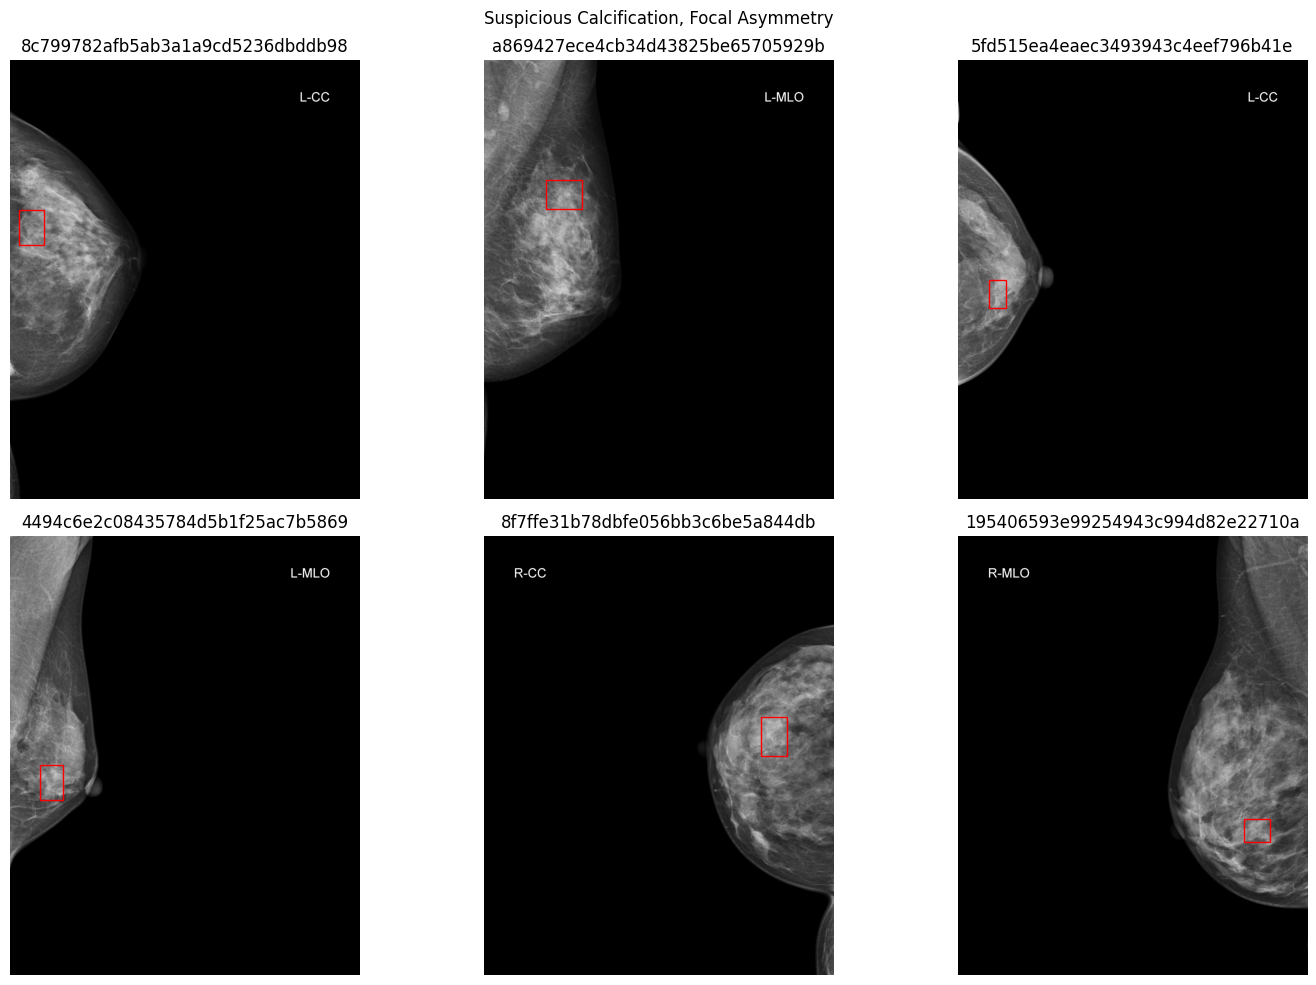

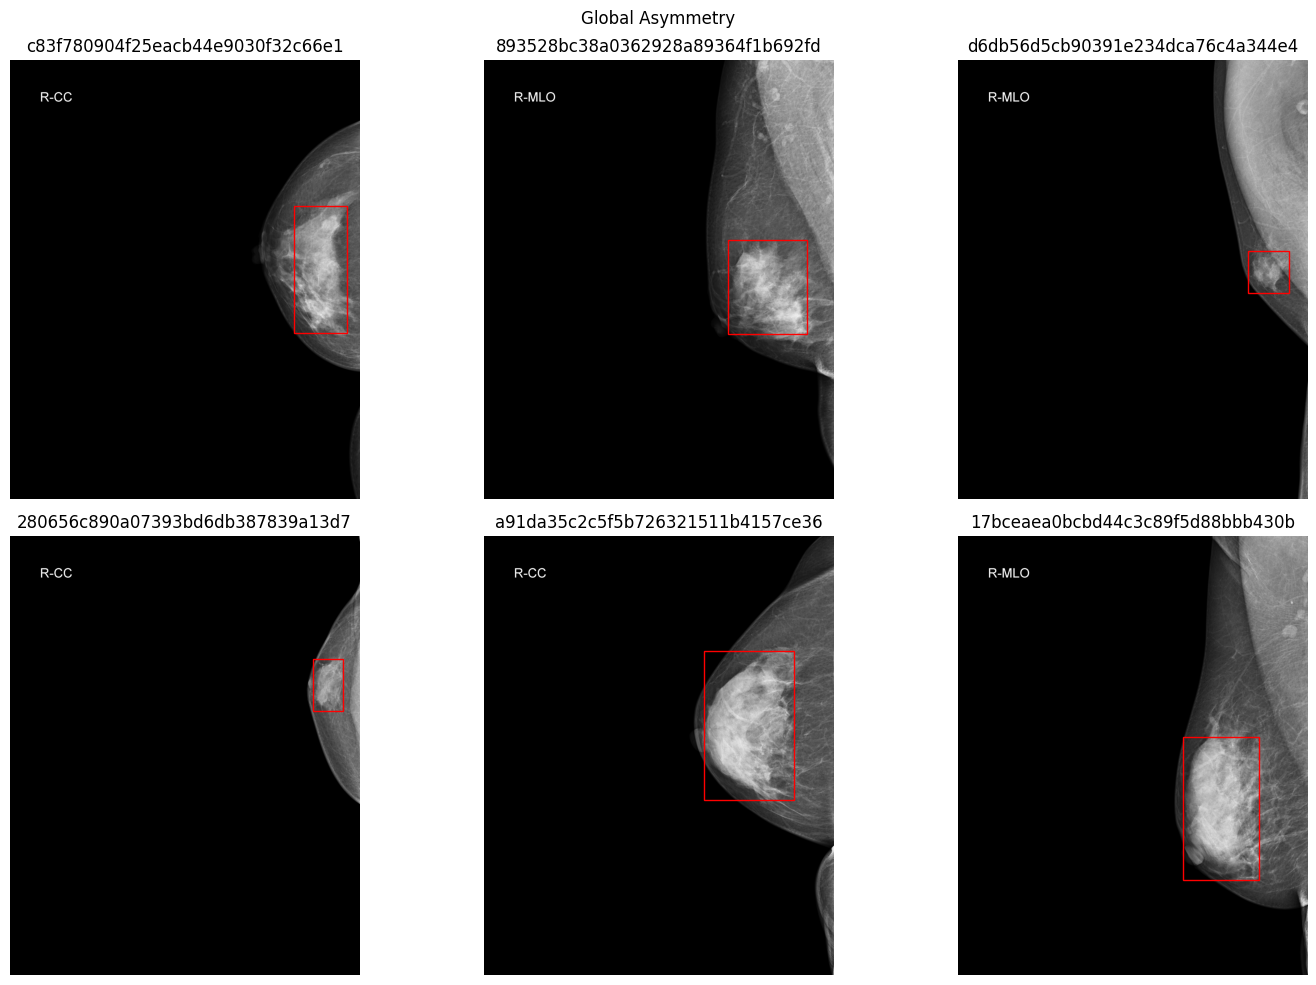

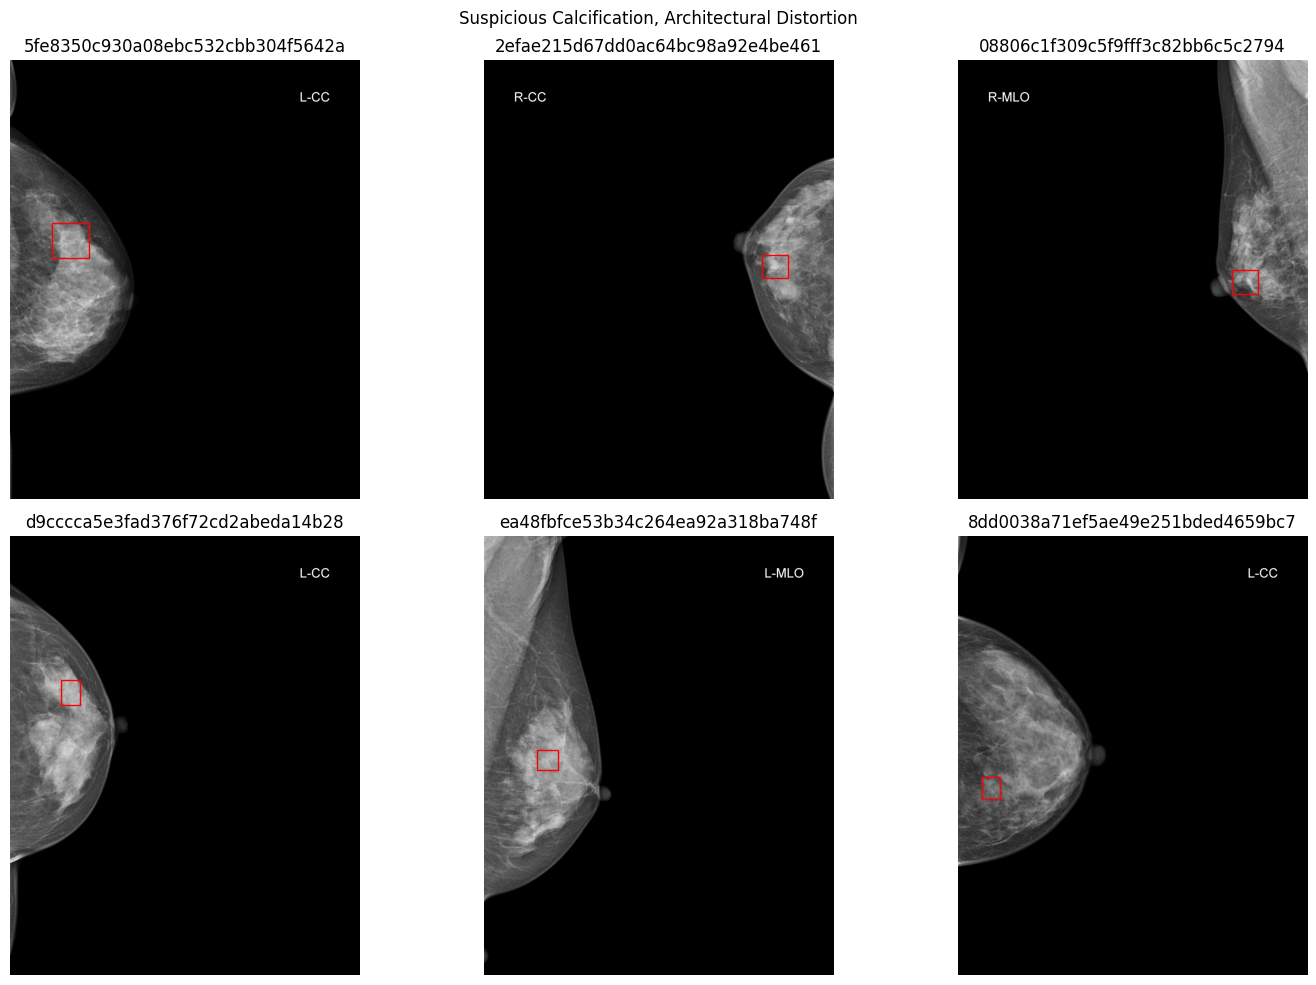

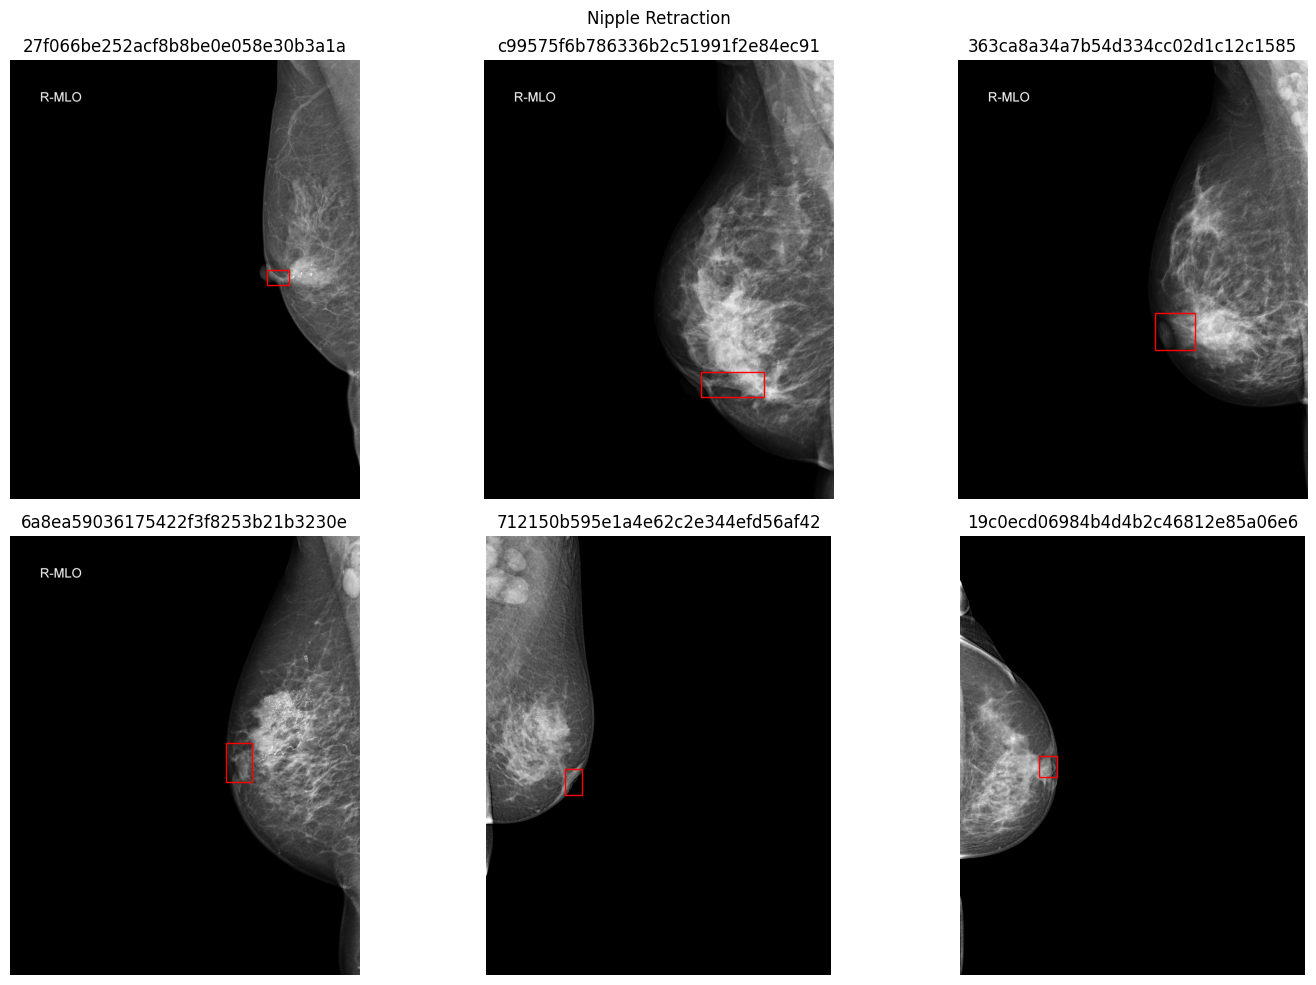

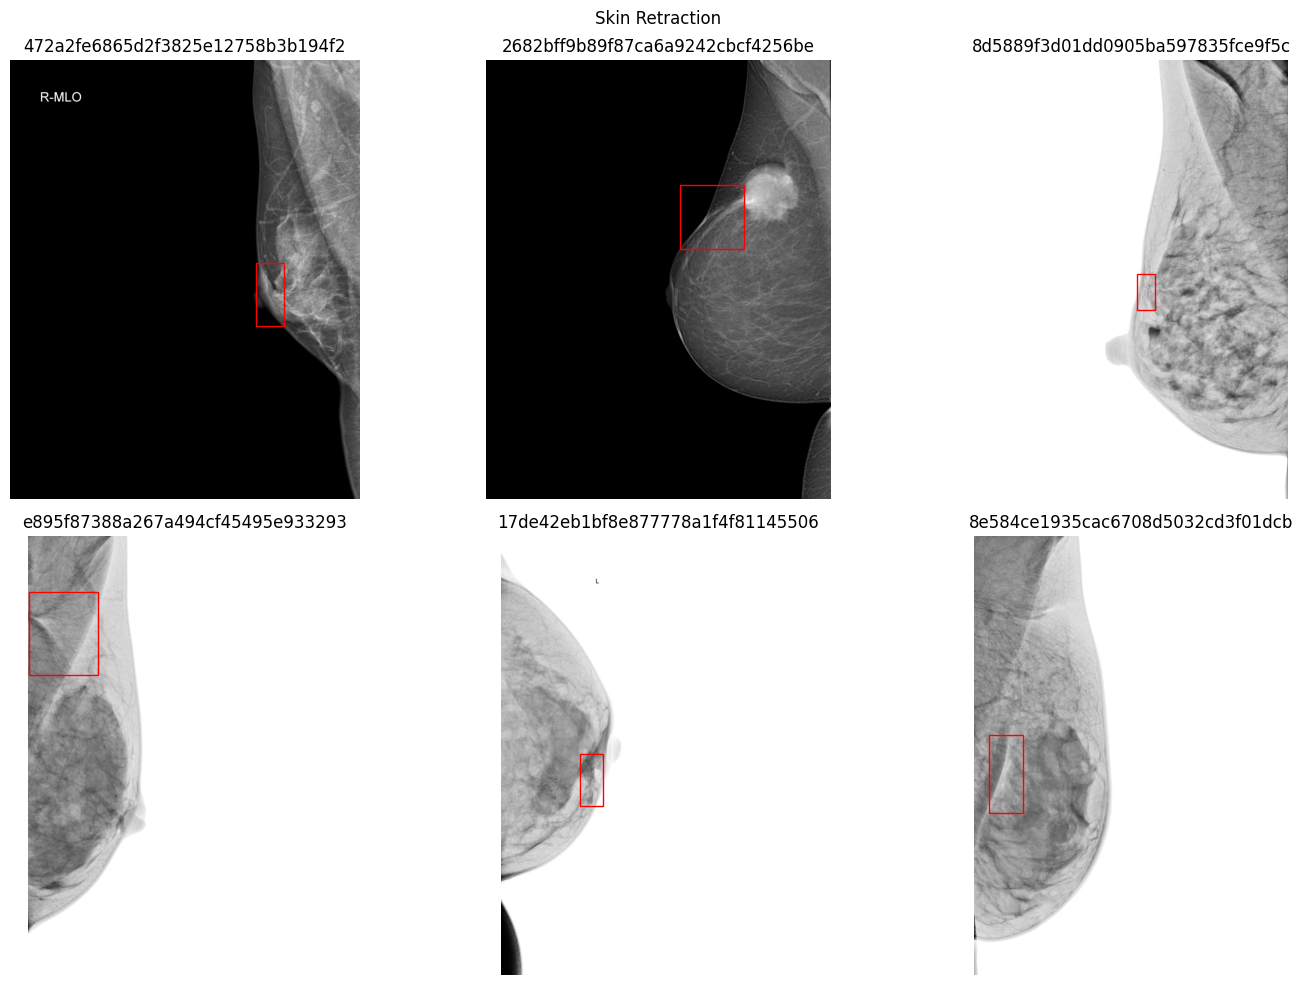

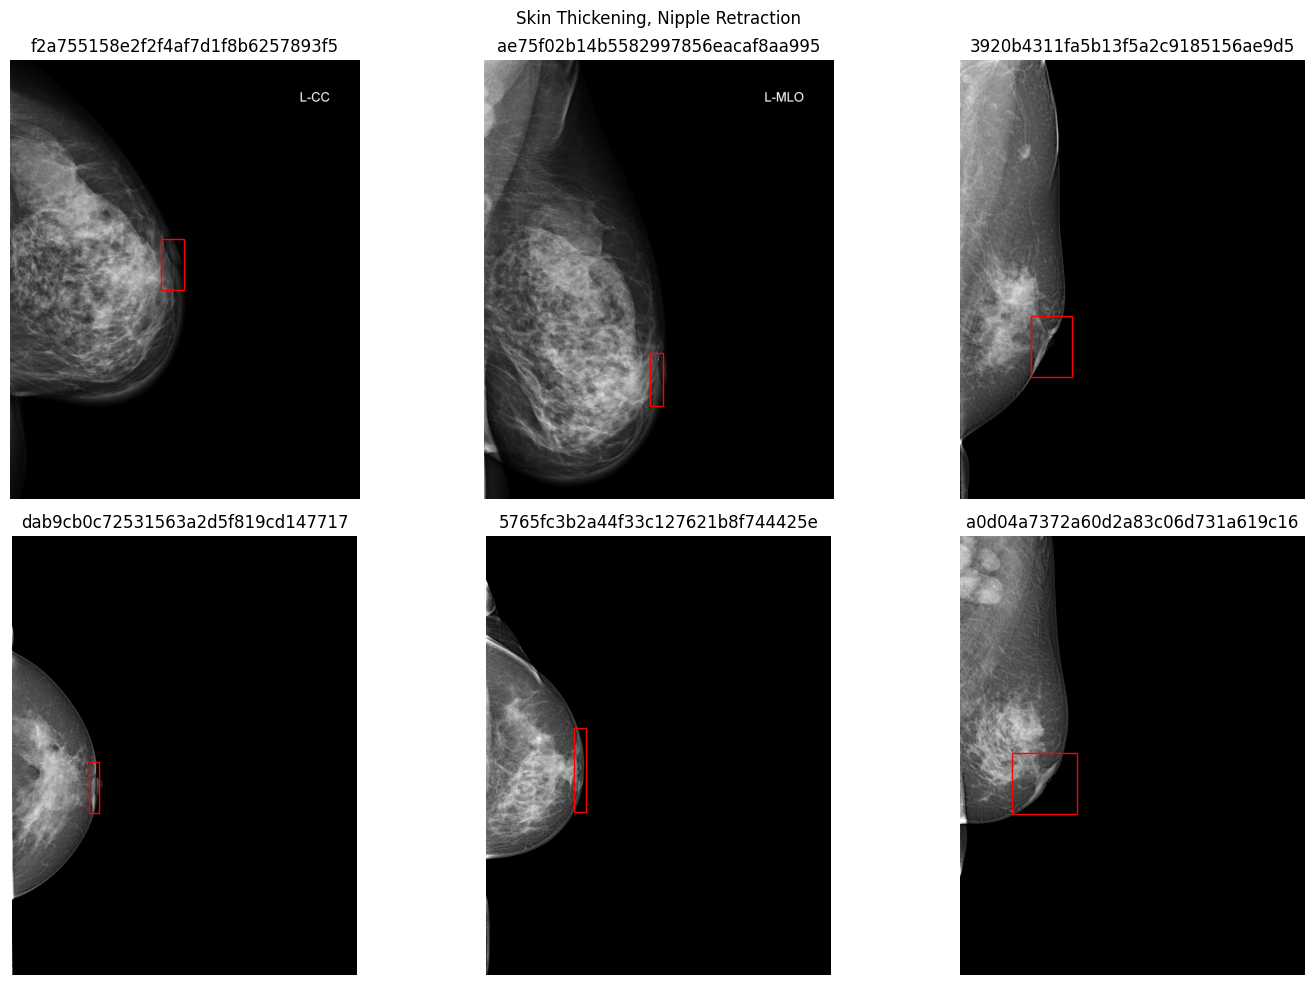

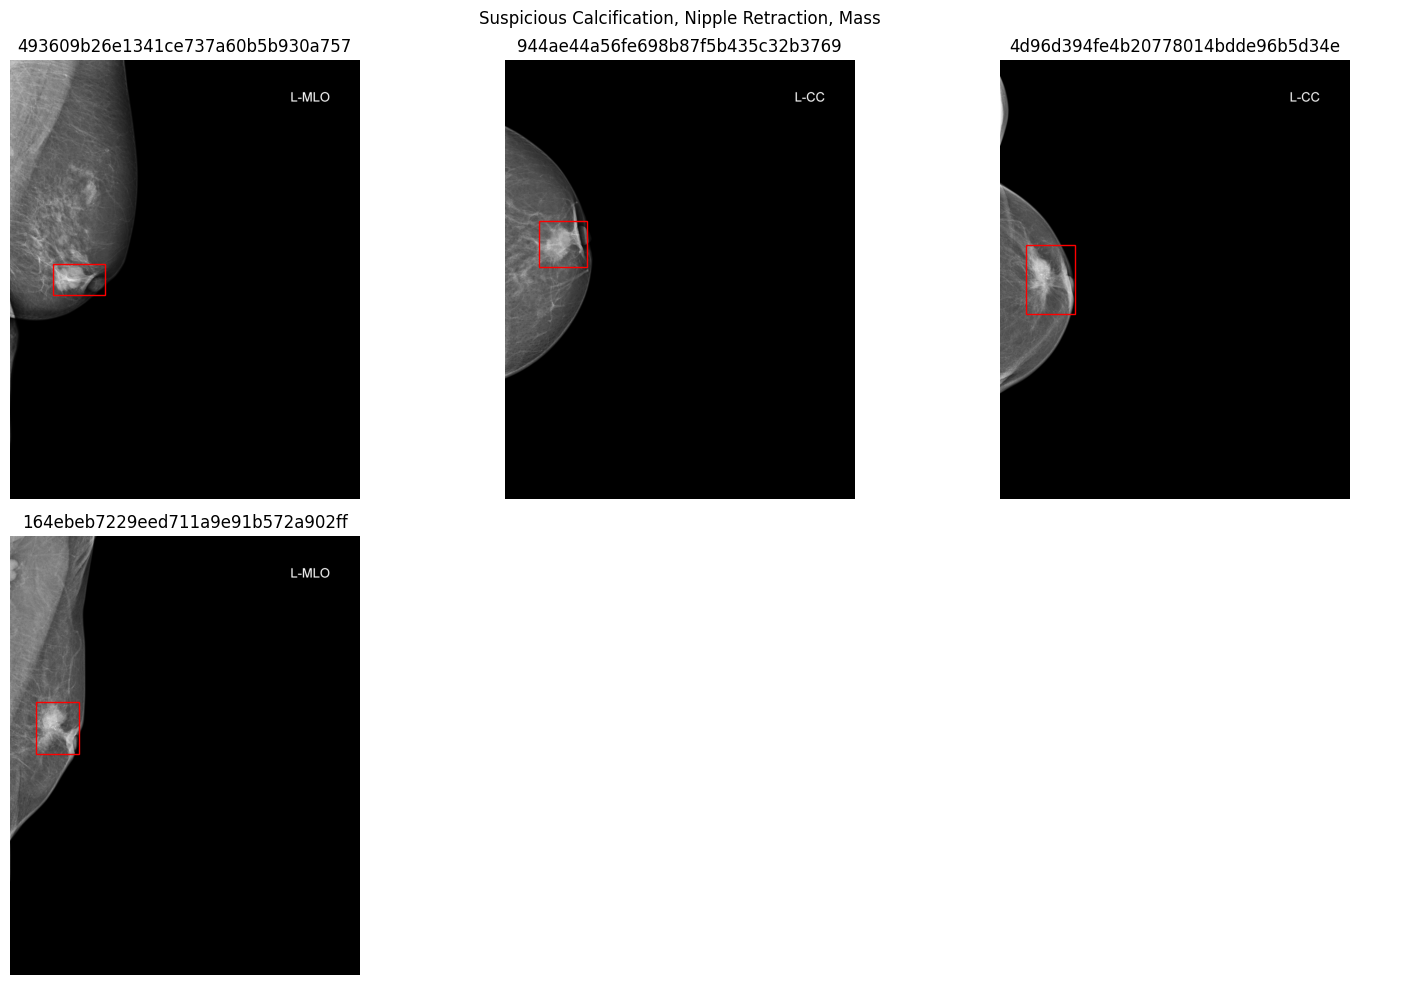

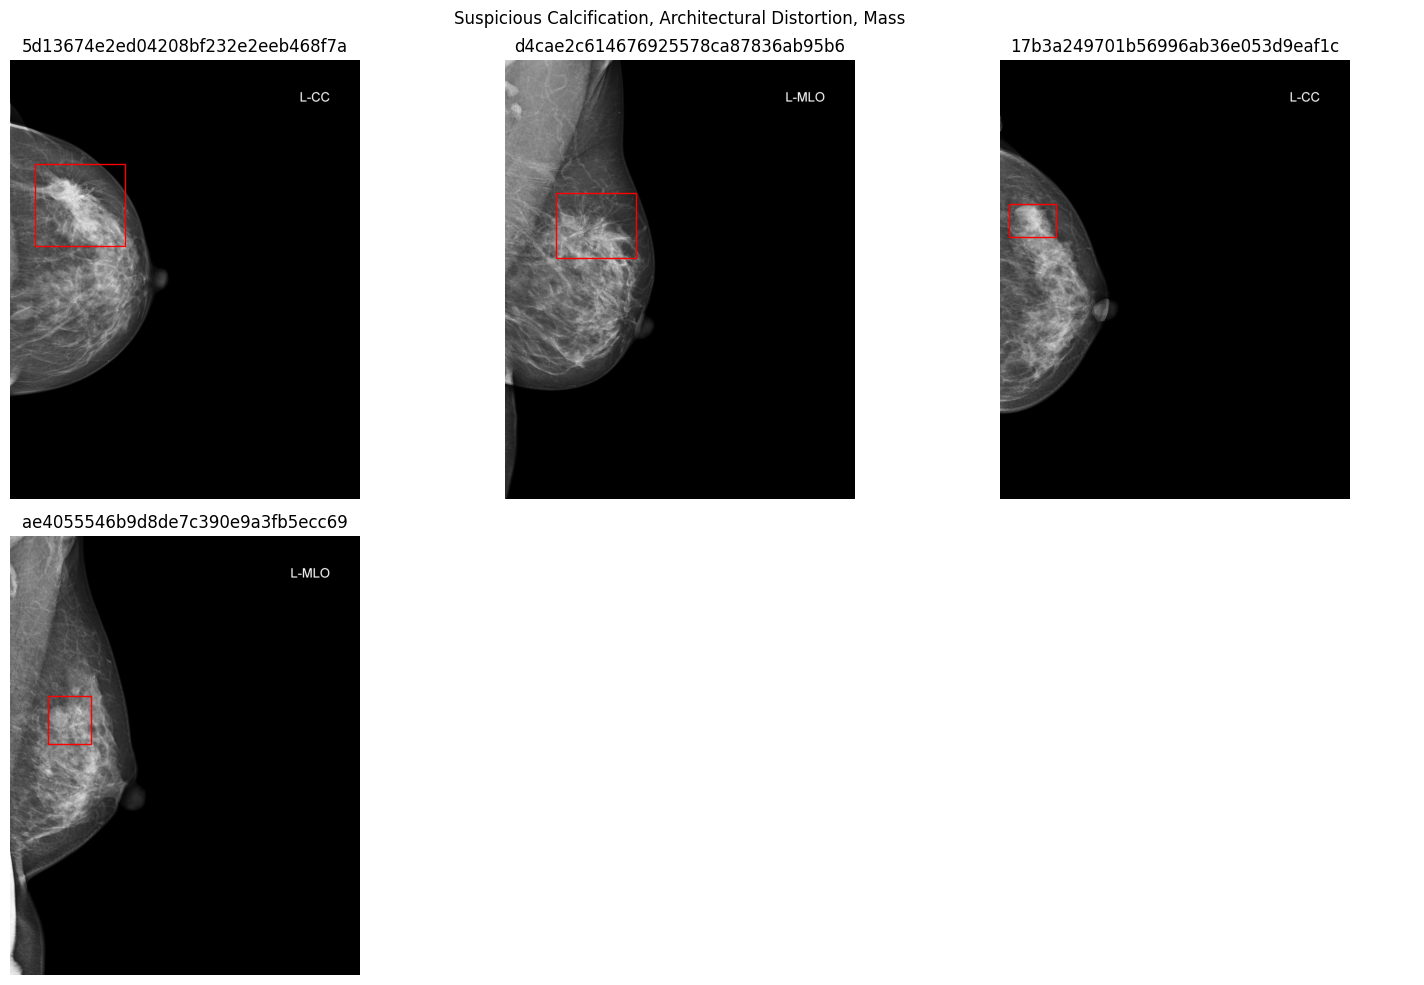

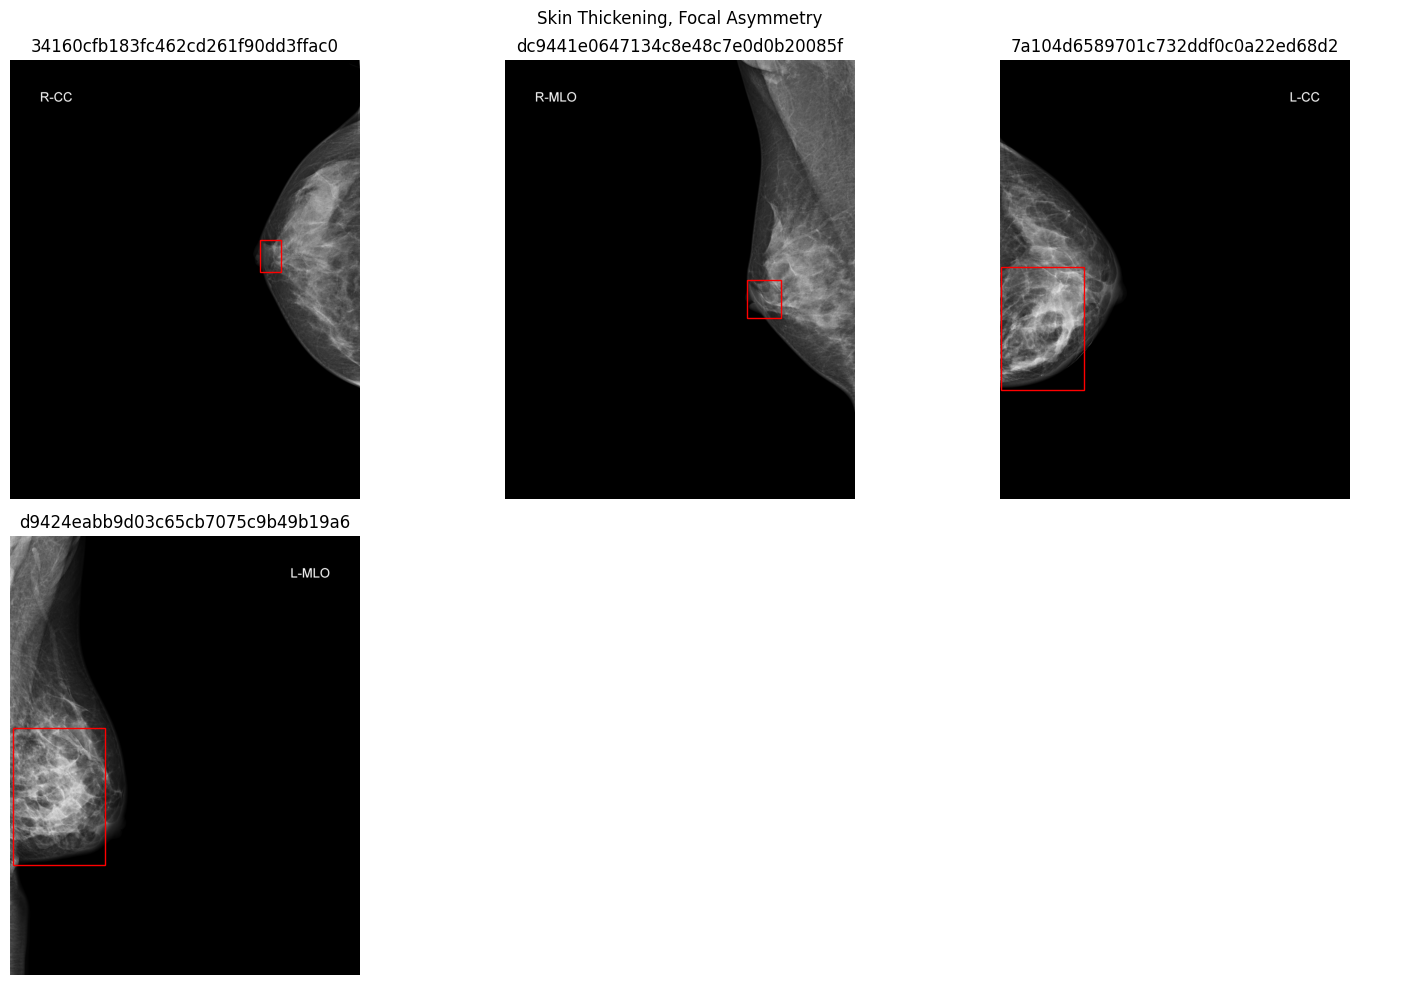

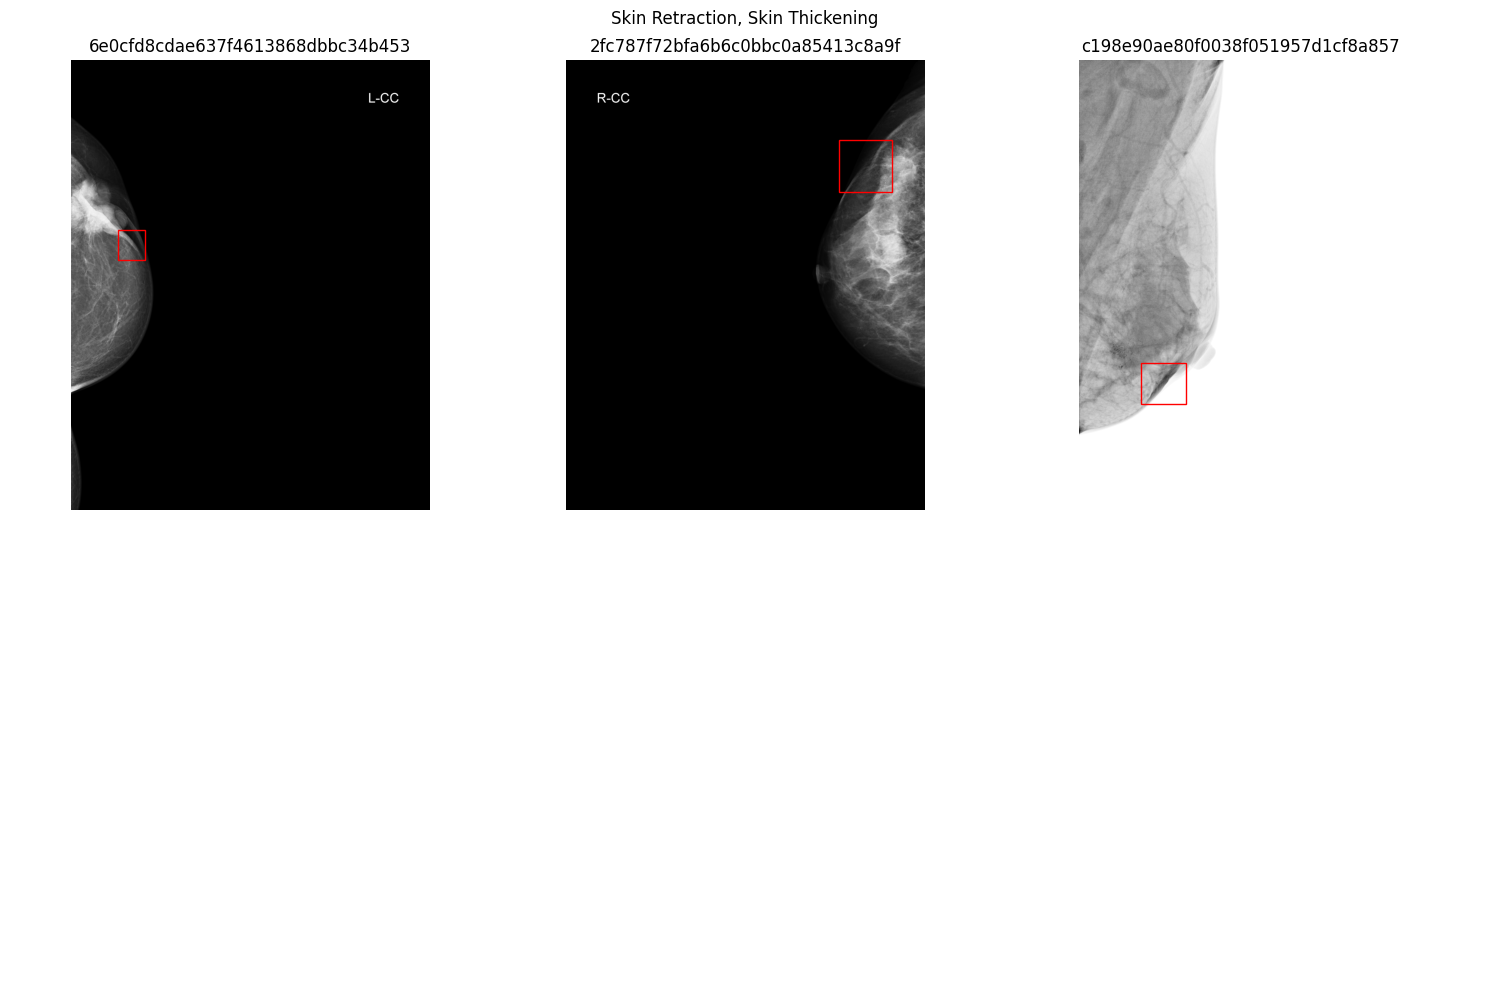

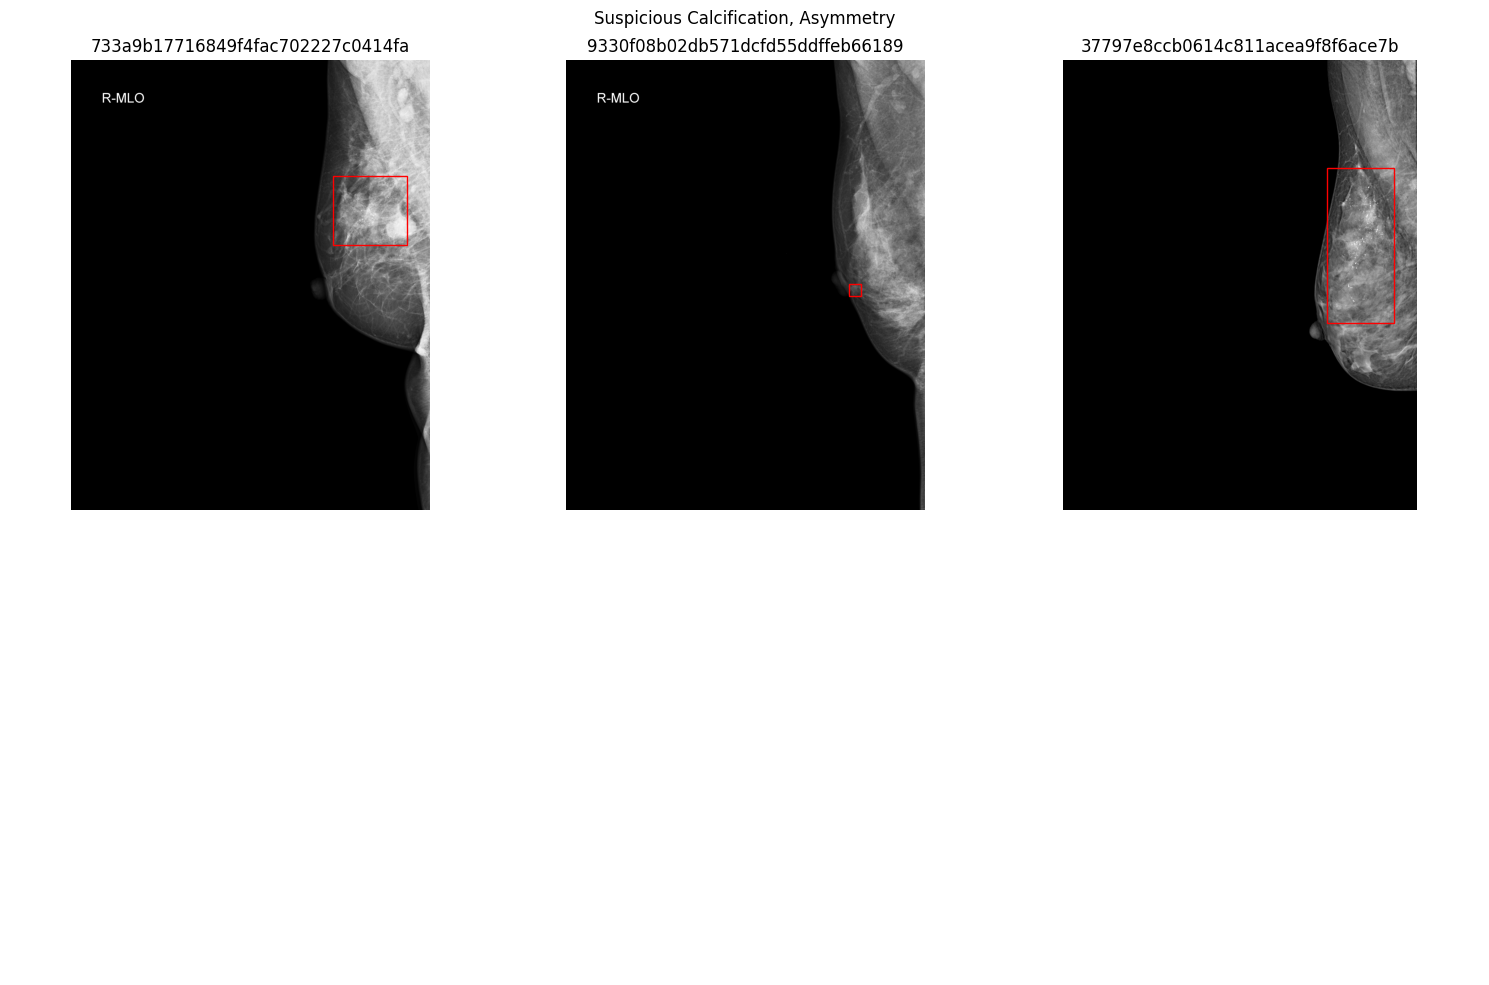

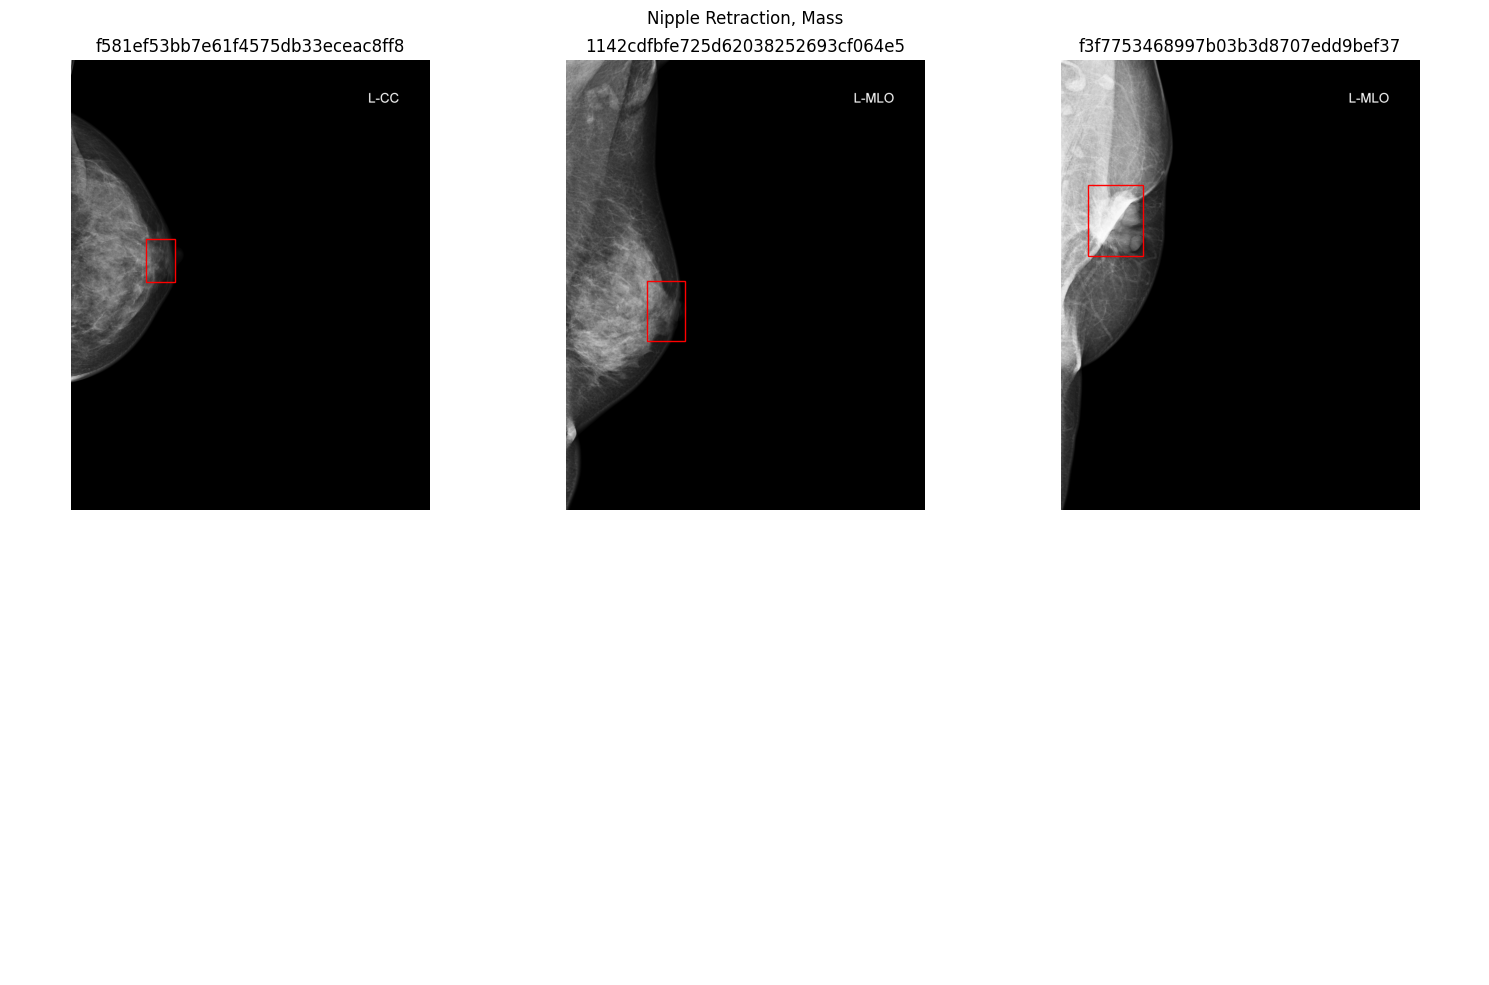

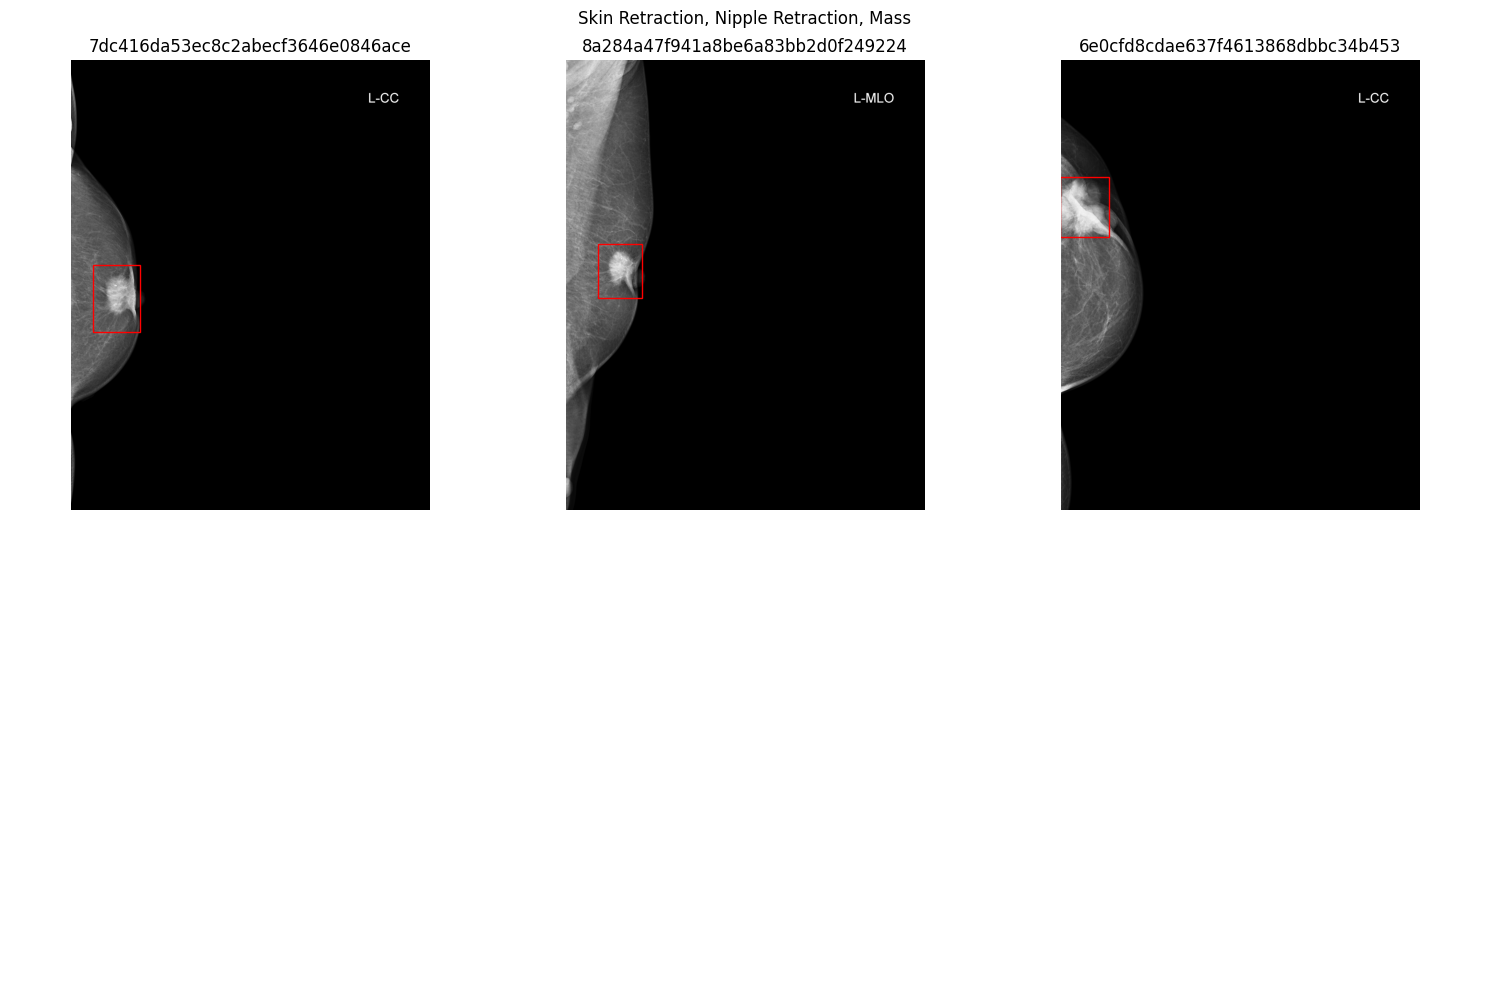

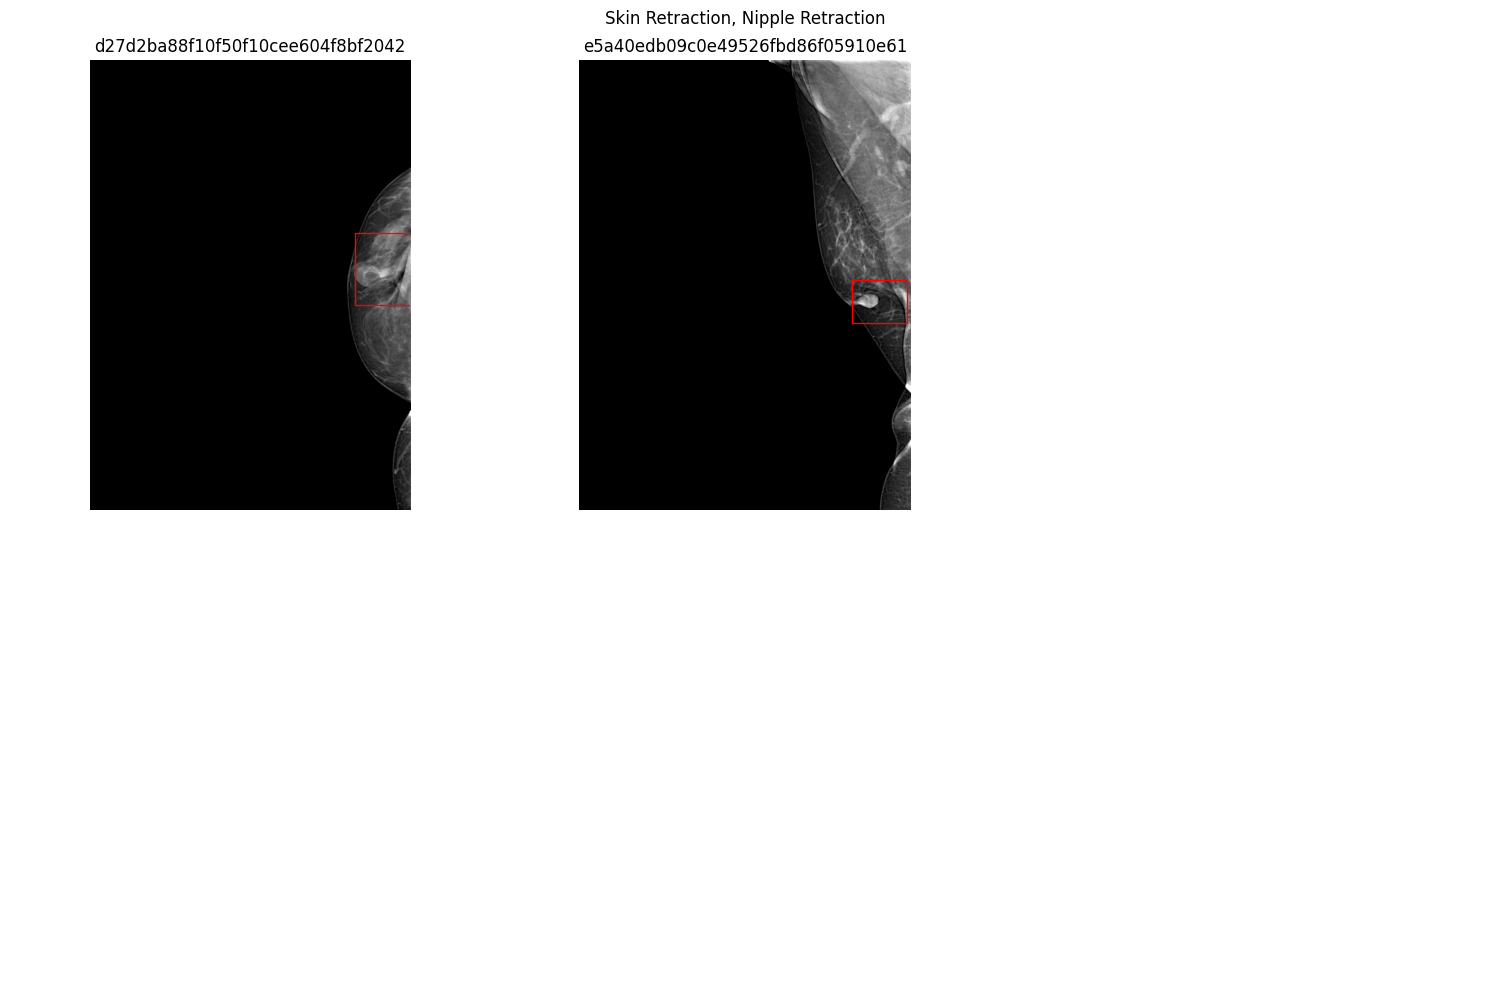

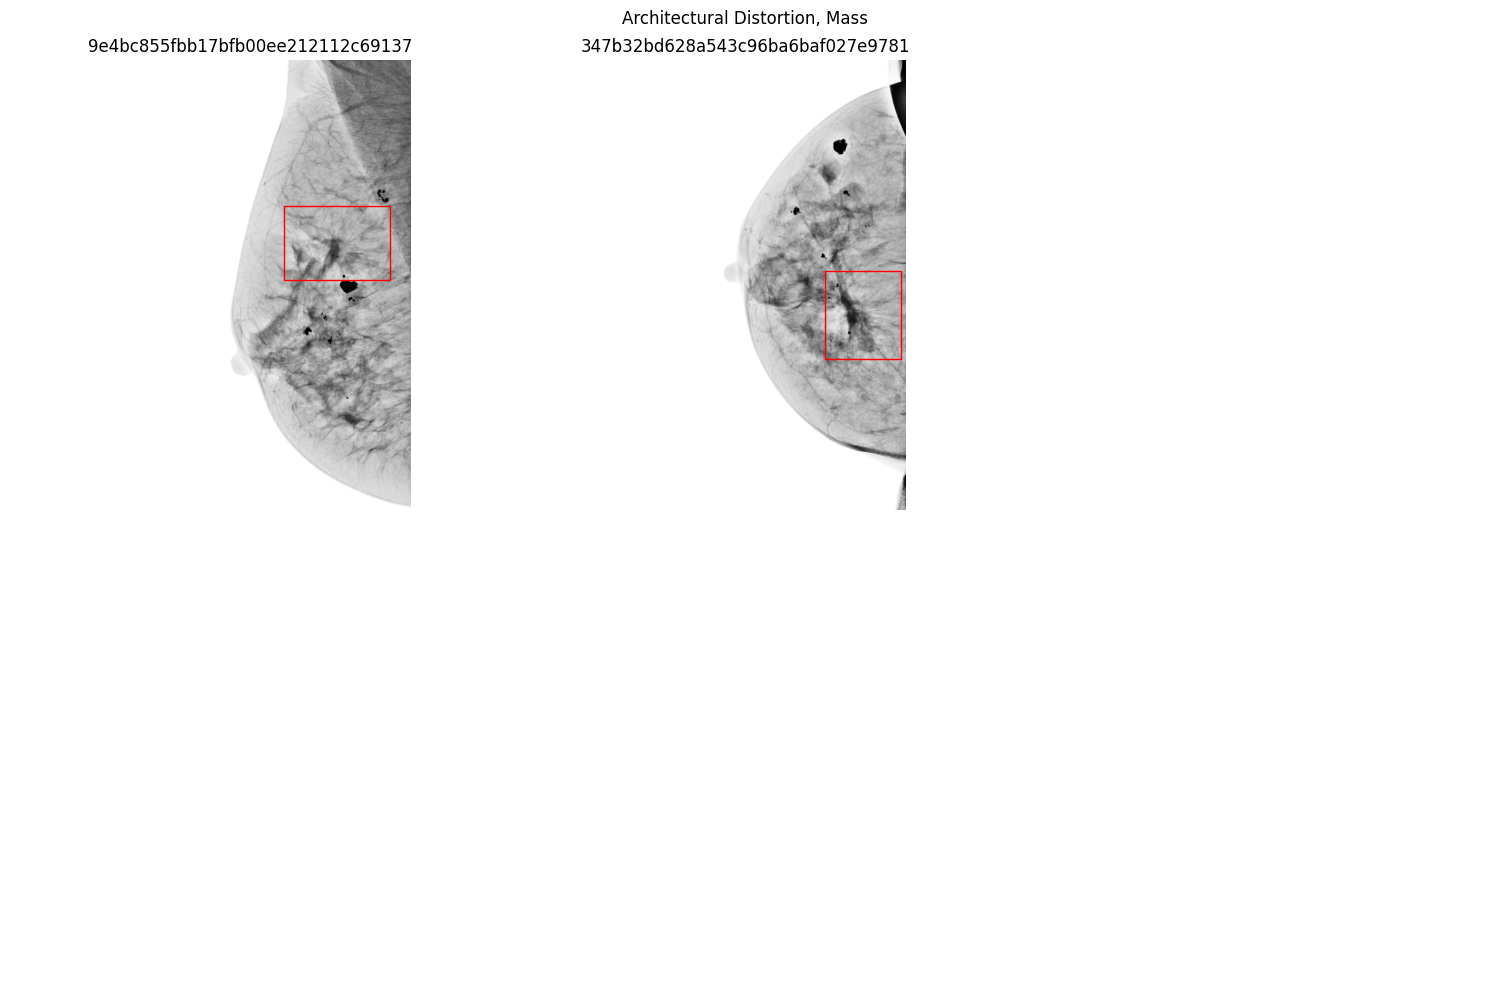

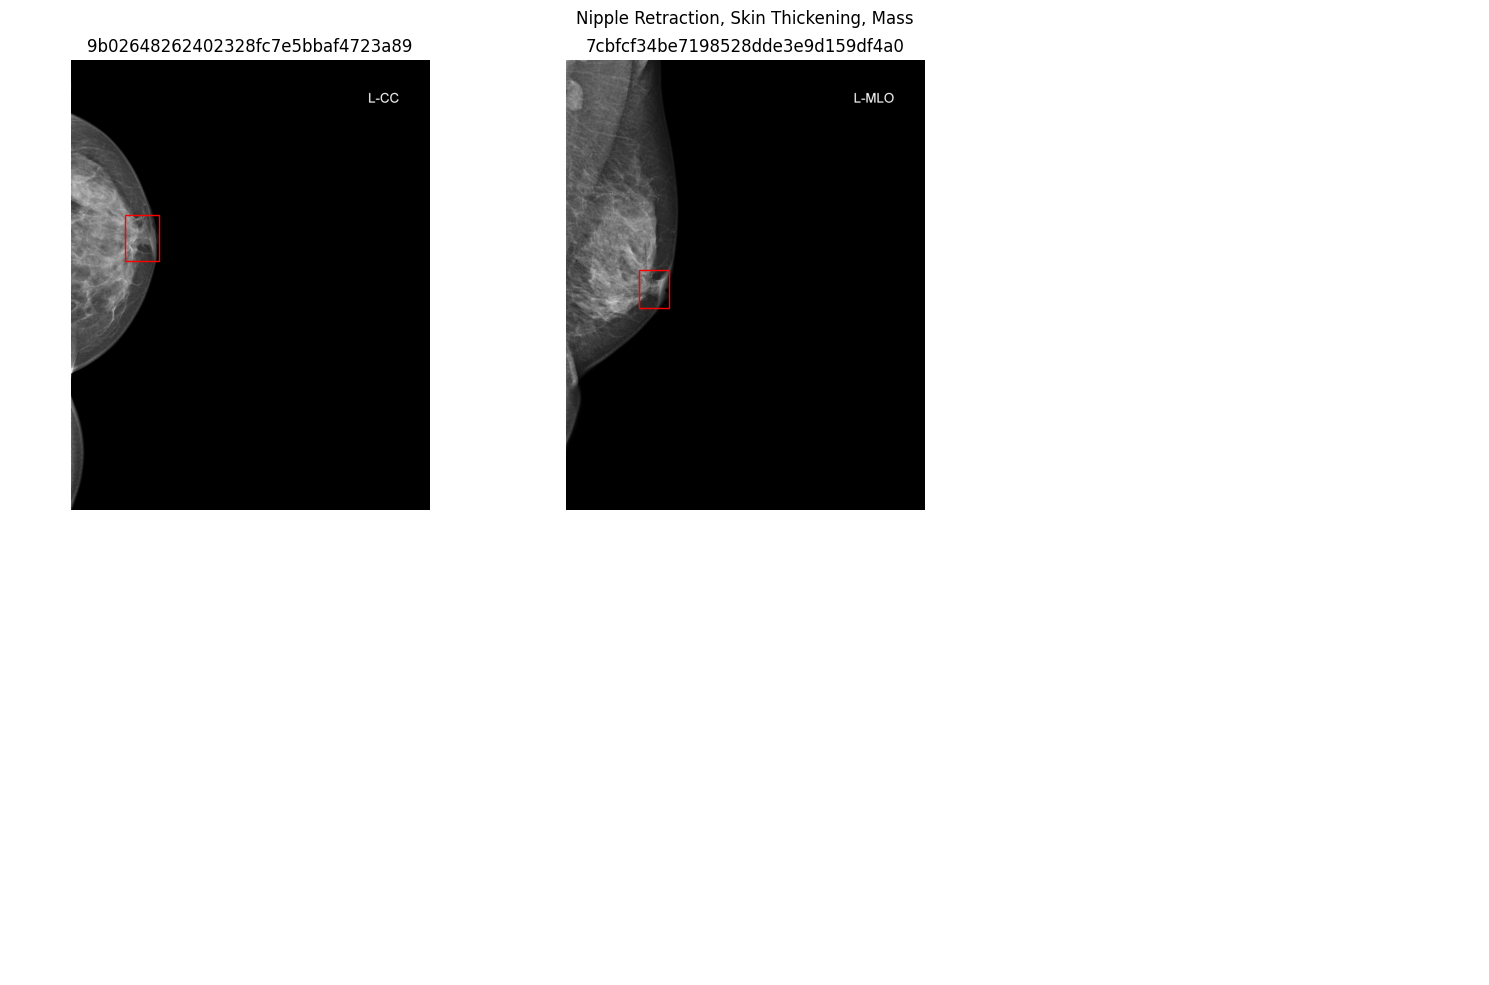

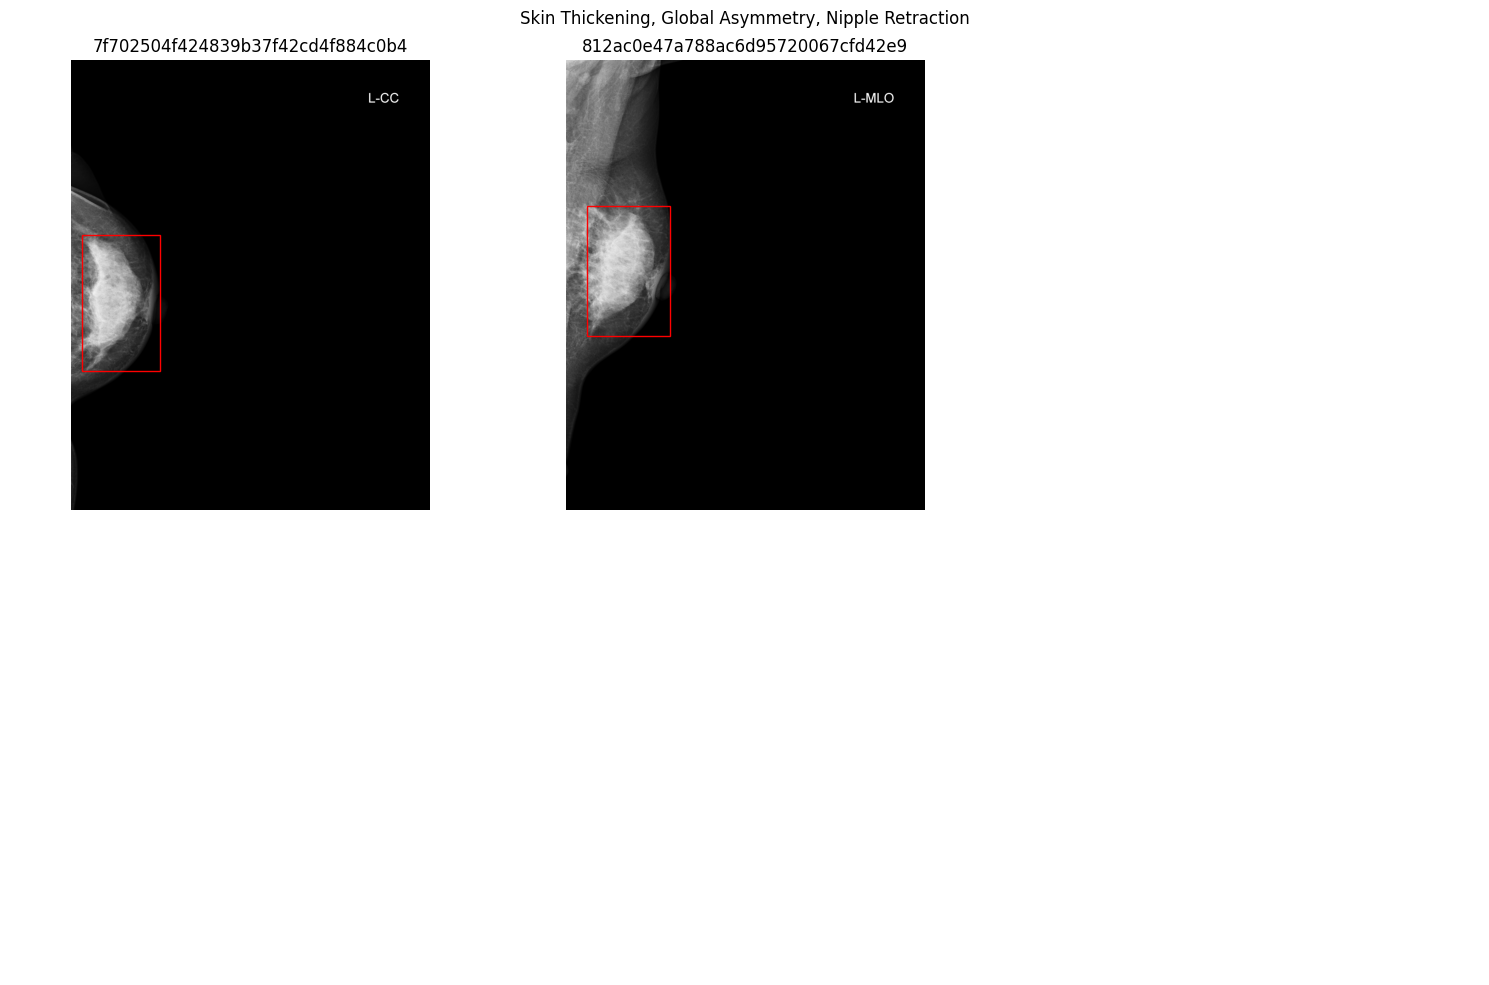

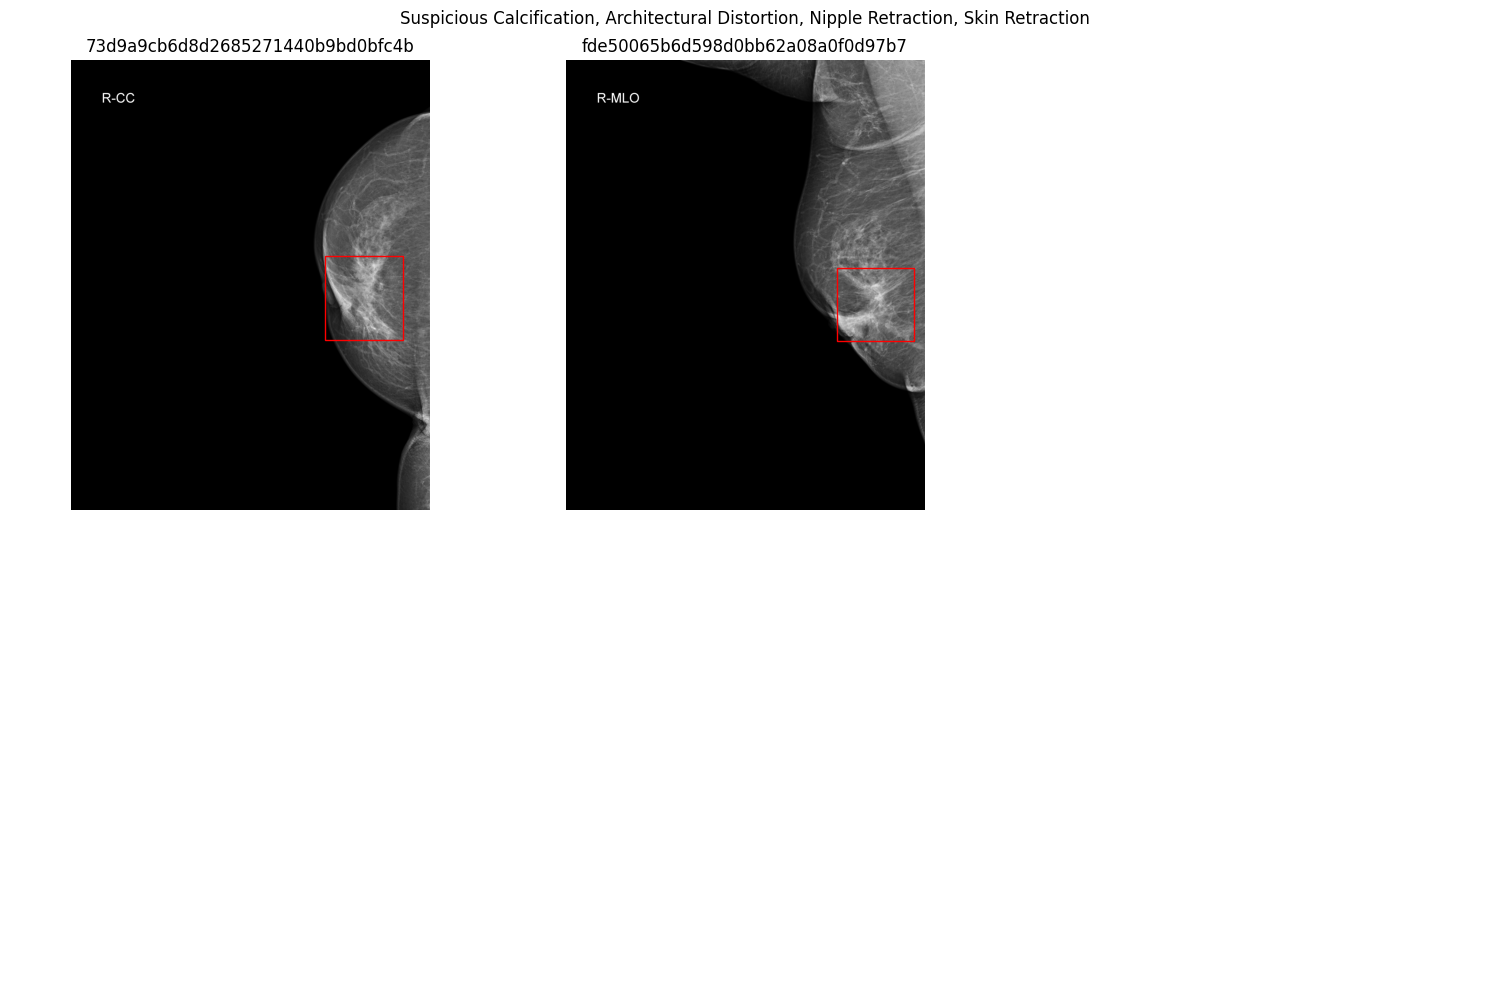

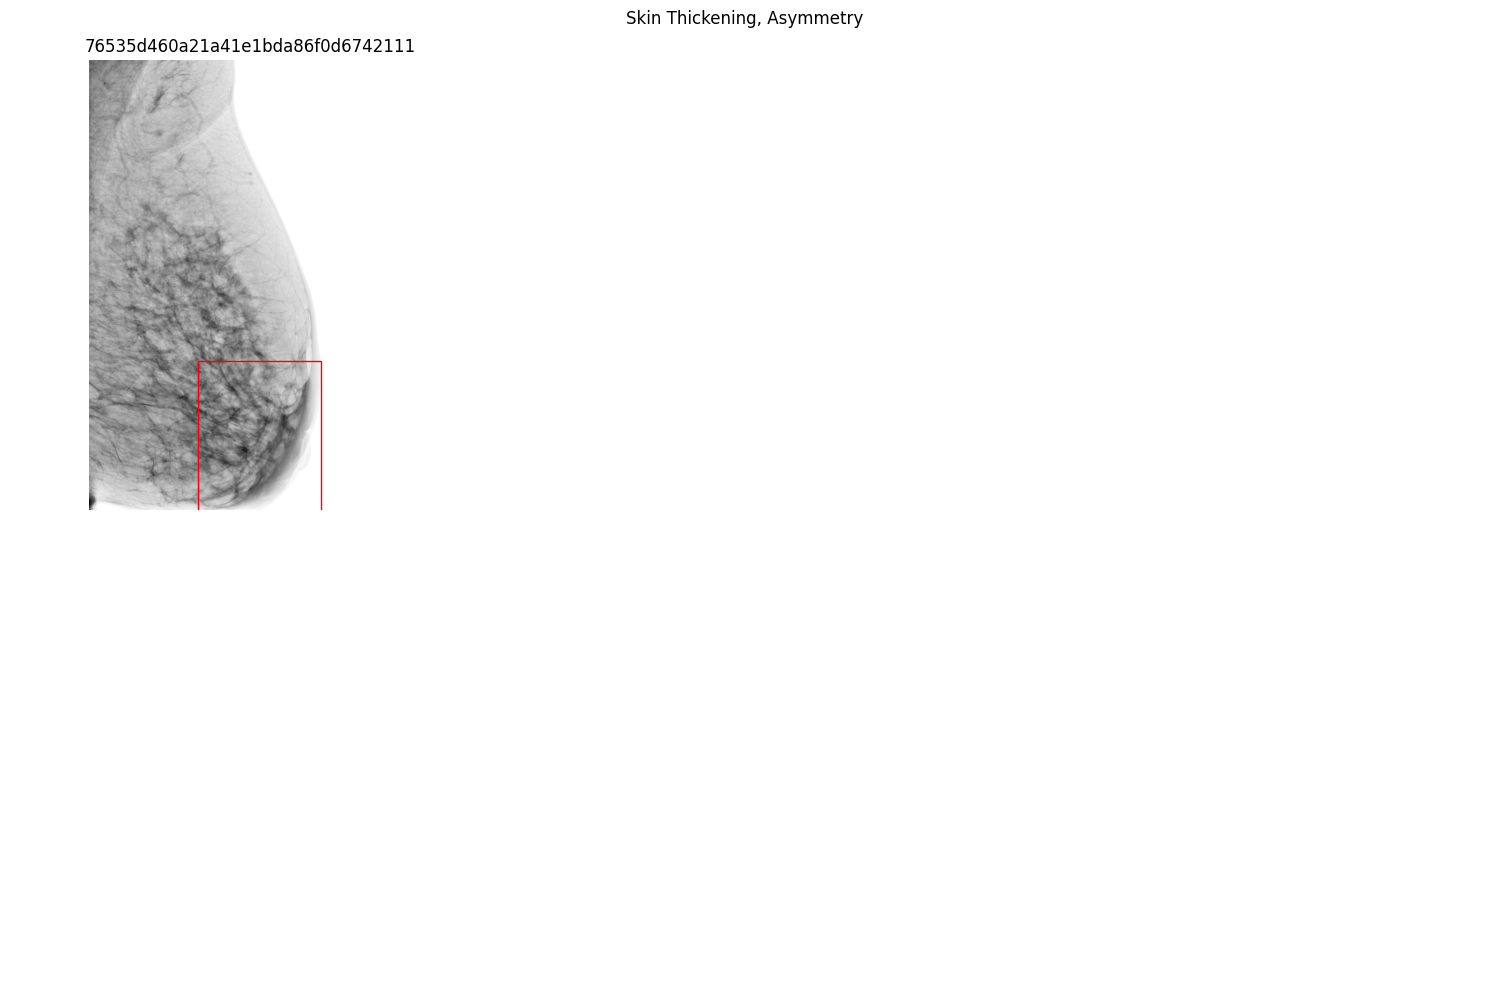

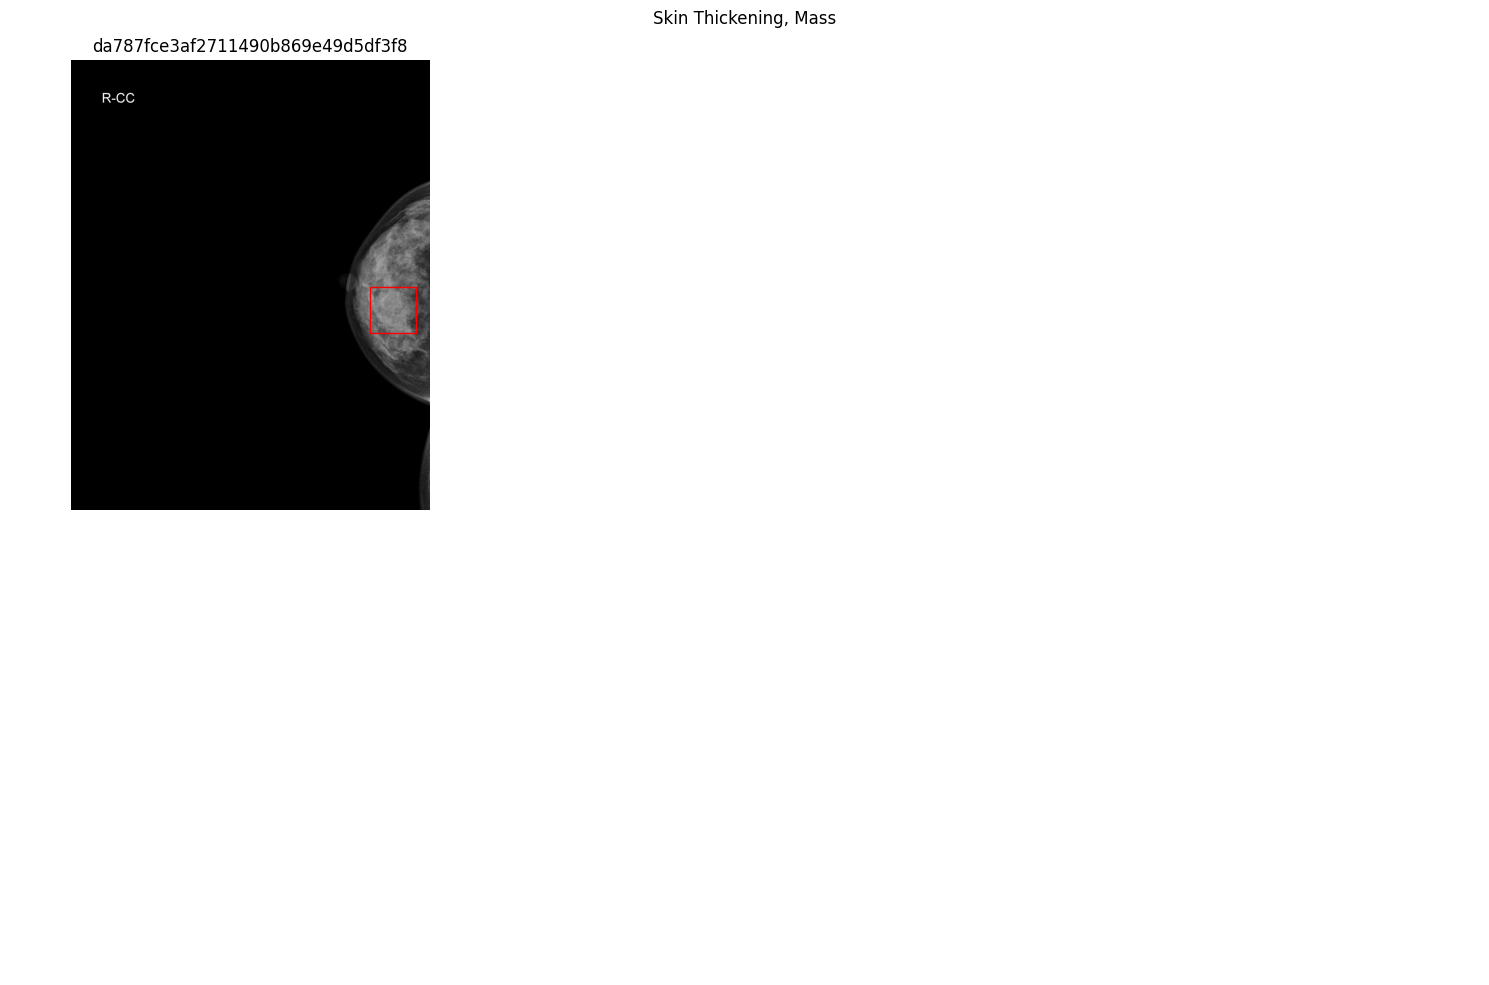

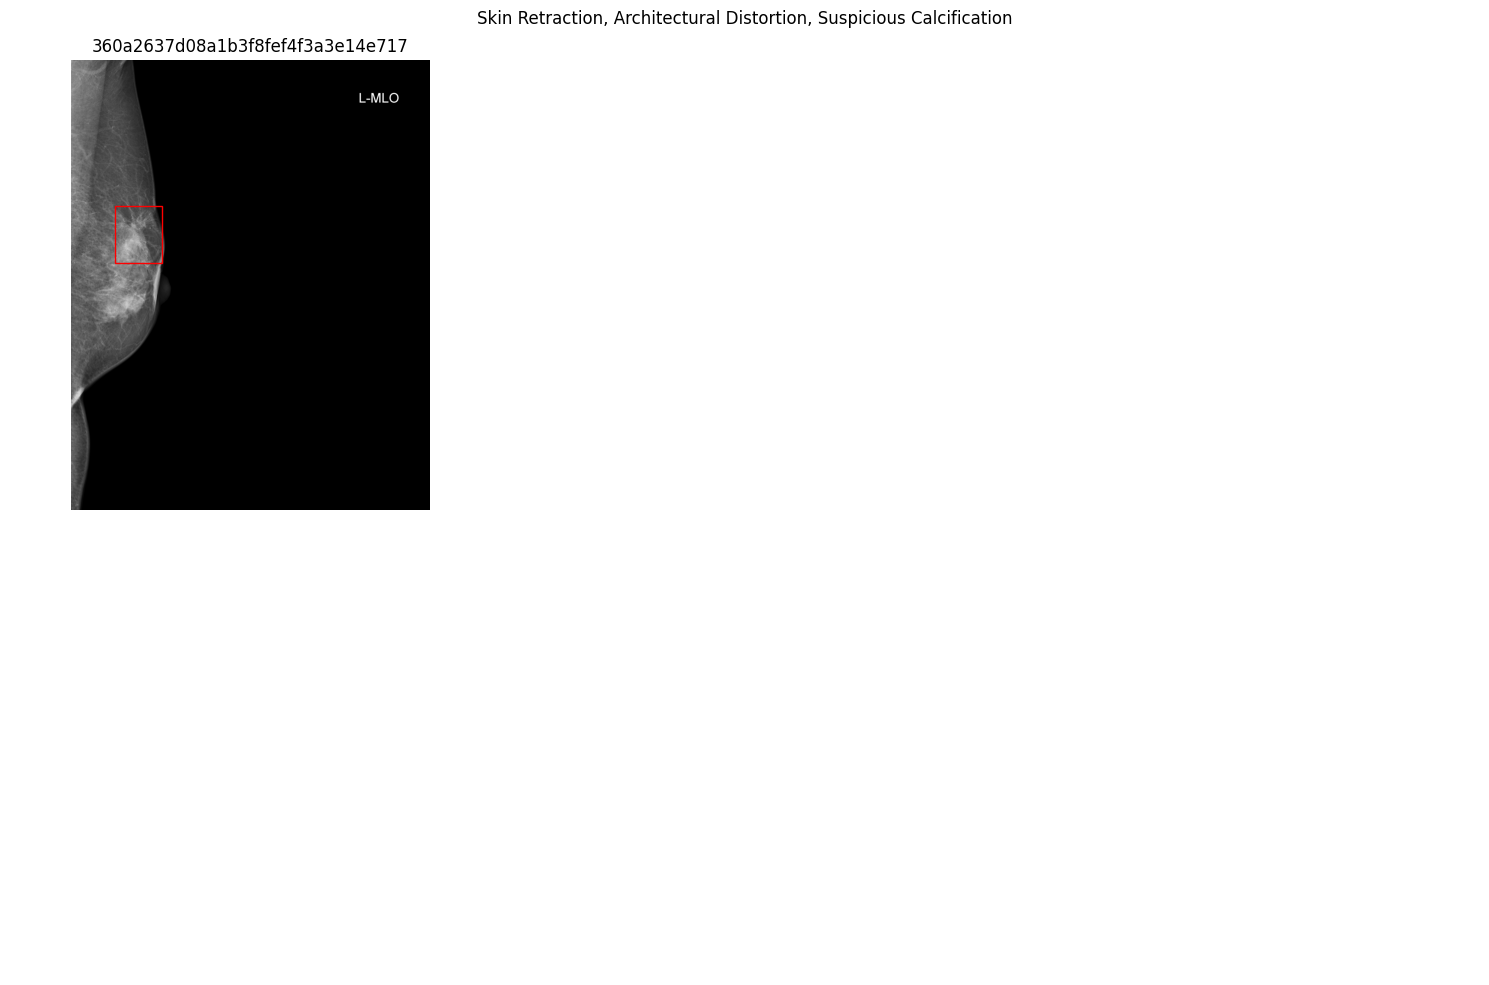

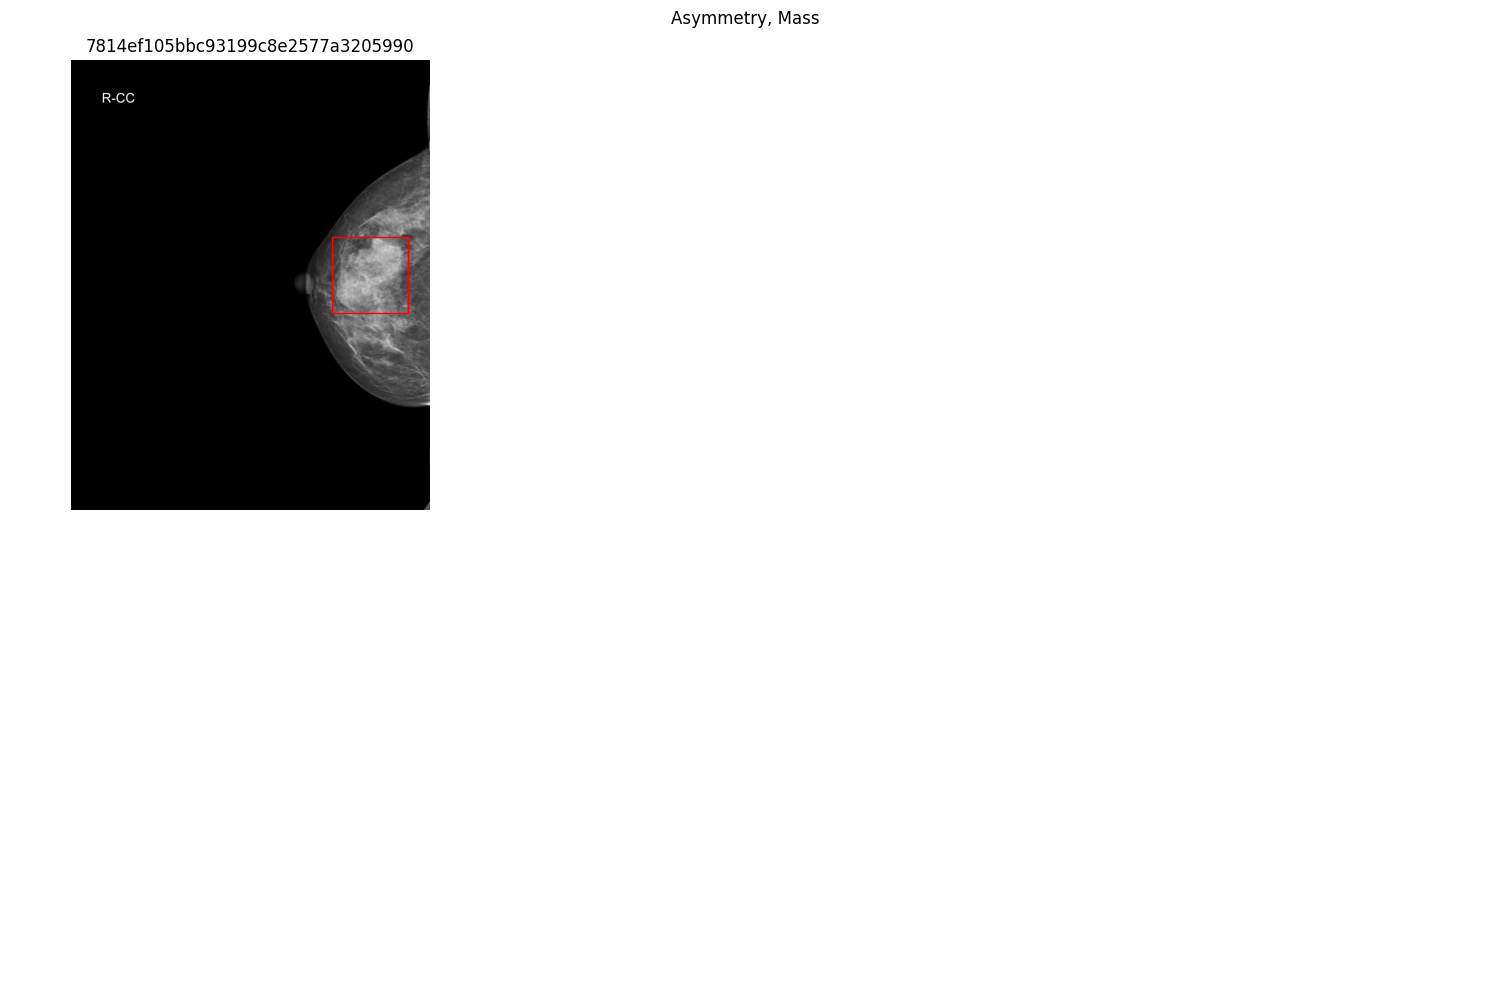

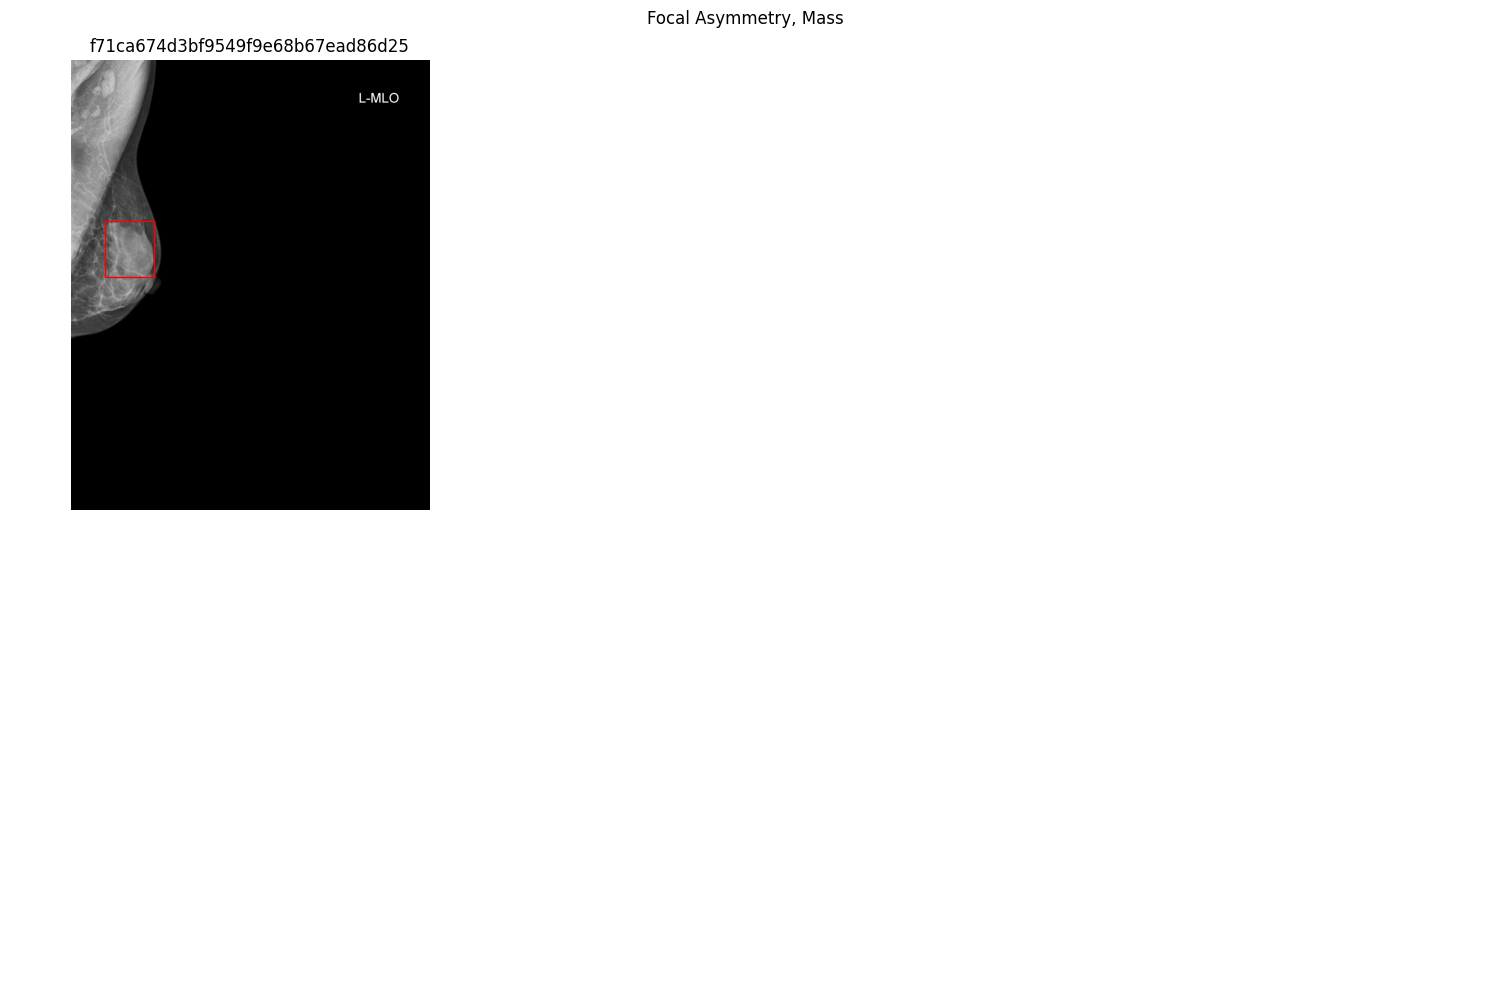

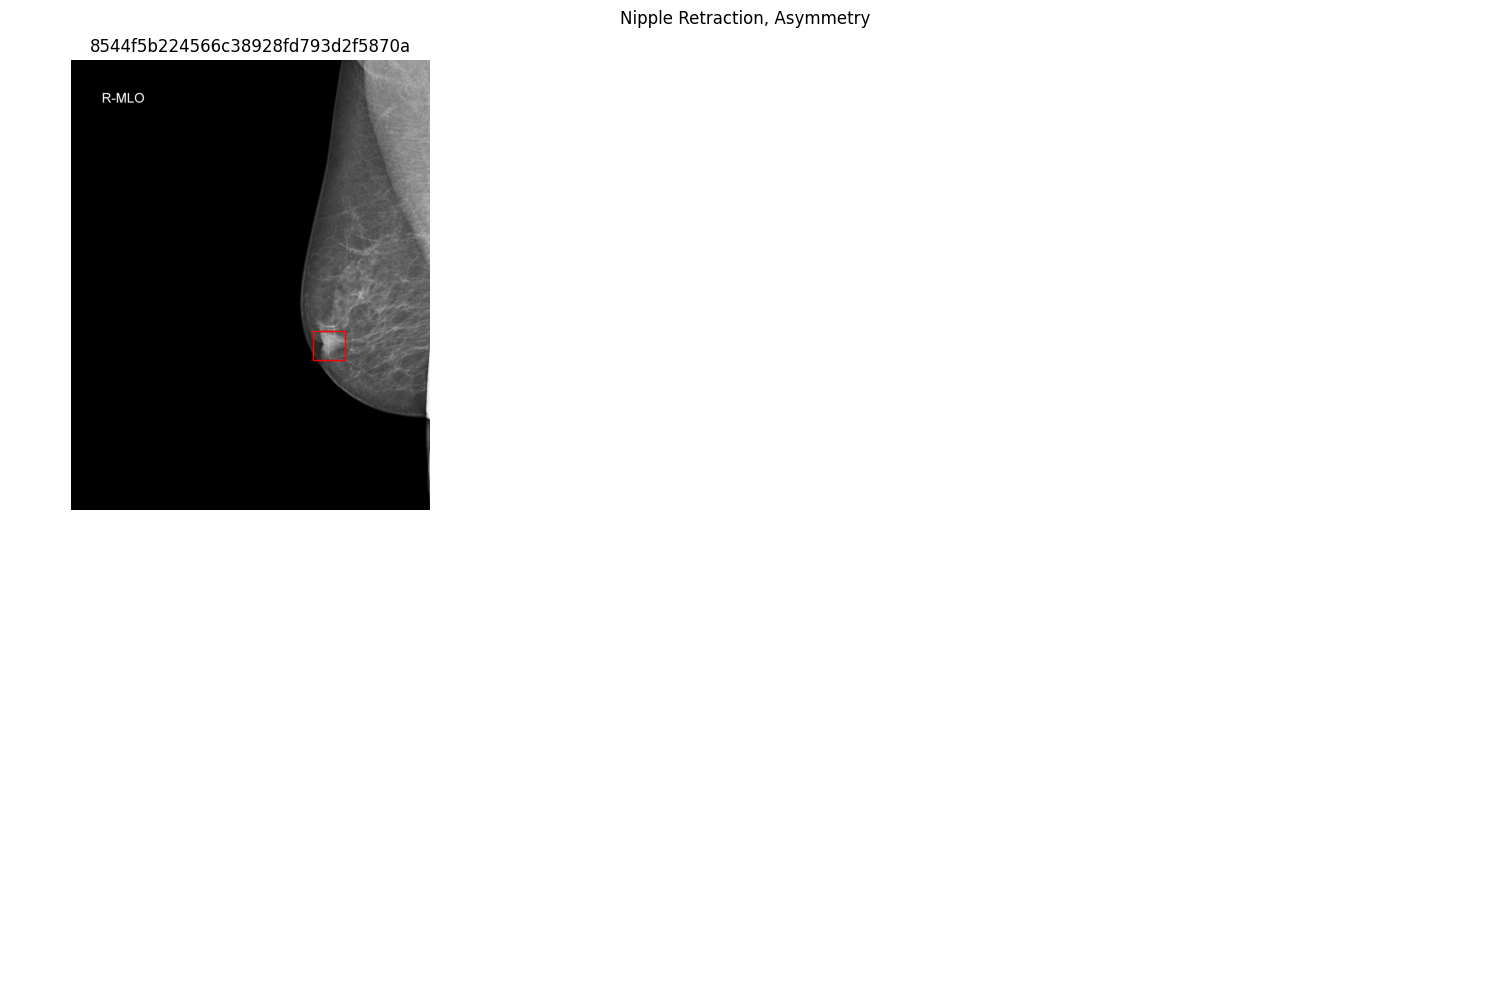

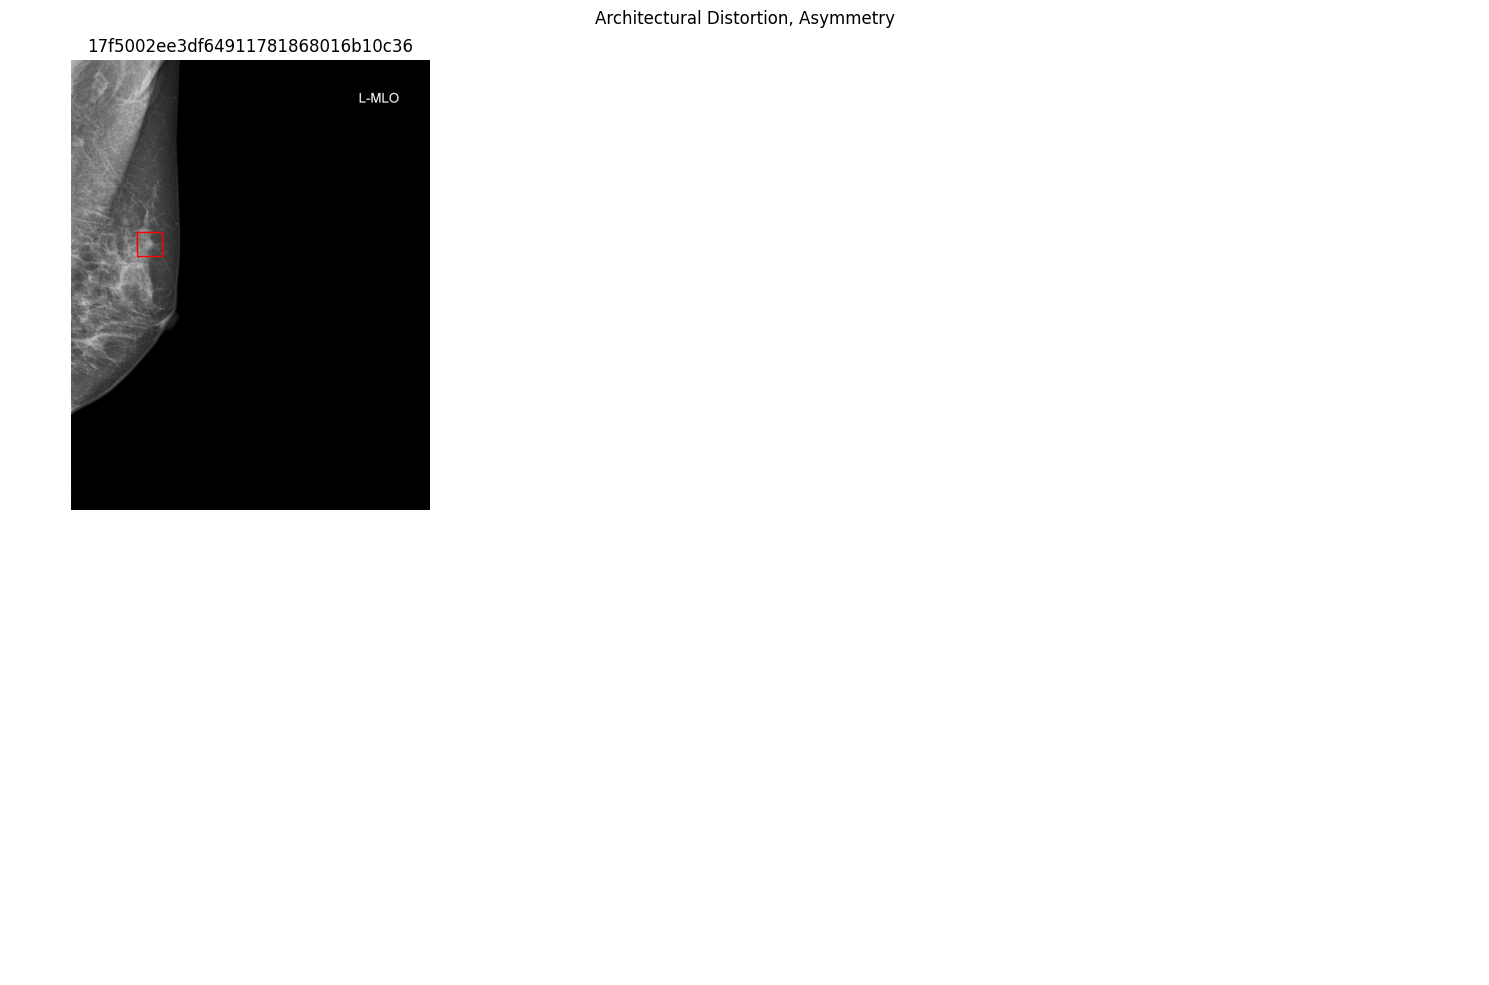

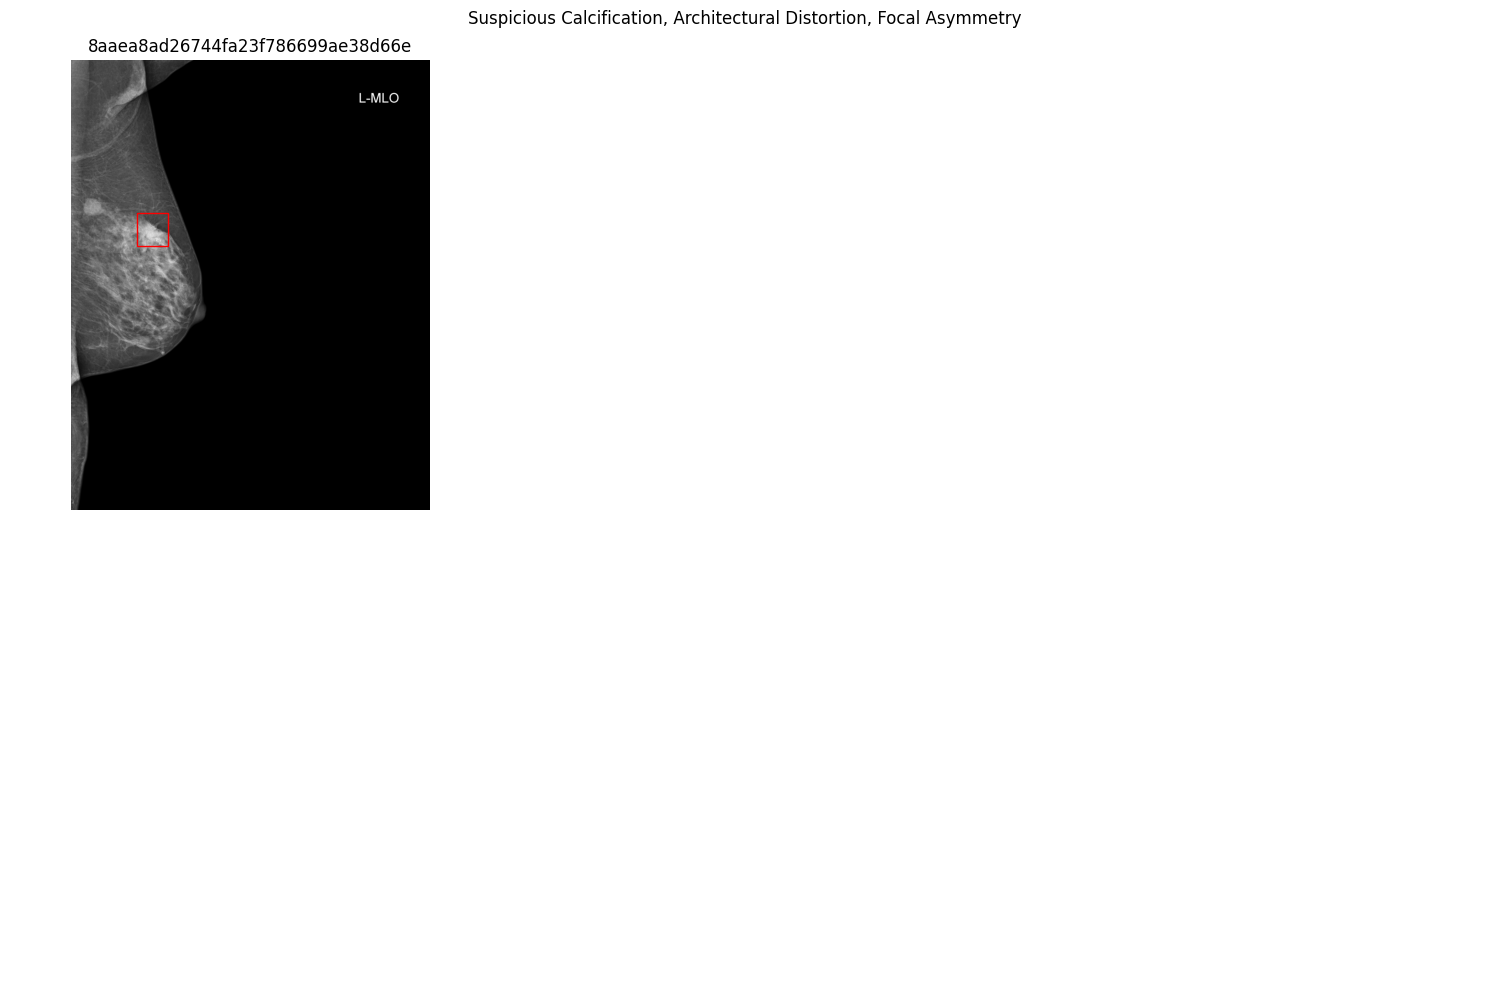

In [3]:
for finding_category in finding_categories[1:].index: # Modificar Indica
    utils.show_sample(finding_category)

### Visualización de Imágen en Particular

1 - red - finding_categories: ['Suspicious Calcification'], 
finding_birads: BI-RADS 5, breast_birads: BI-RADS 5, Photometric Interpretation: MONOCHROME2
2 - blue - finding_categories: ['Suspicious Calcification'], 
finding_birads: BI-RADS 4, breast_birads: BI-RADS 5, Photometric Interpretation: MONOCHROME2
3 - green - finding_categories: ['Suspicious Calcification', 'Architectural Distortion'], 
finding_birads: BI-RADS 4, breast_birads: BI-RADS 5, Photometric Interpretation: MONOCHROME2


<Axes: >

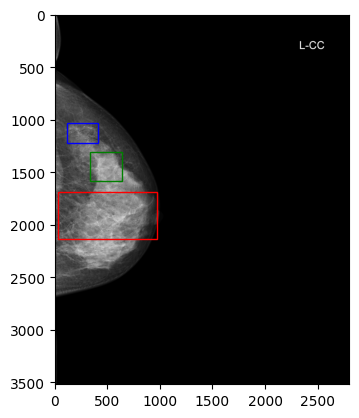

In [4]:
utils.show_image('5fe8350c930a08ebc532cbb304f5642a')

## Windowing y VOI LUT

### Window center and window width

Hace referencia a la luminosidad (brightness) y al contraste. Se suele escribir como C:W (e.g. 400:2000 might be good for visualising bone, while 50:350 might be a better choice for soft tissue).

En el gráfico, el eje Y muestra la luminosidad y el eje X la intensidad de la imagen.
![Image](Resources/img1.png)

[Referencia](https://web.archive.org/web/20150920230923/http://www.mccauslandcenter.sc.edu/mricro/dicom/index.html)

### VOI LUT
Debido a que el rango de valores de los pixels es mayor  (10 - 16 bits) que el que suelen tener las pantallas (8bits), por lo tanto solo se dispone de 256 tonos de grises y se requiere mapear many-to-one pixels usando una Look Up Table (LUT). Establecer el Window Width y Window Level resulta en un Values of Interest (VOI) LUT que se aplica a la imagen. Esto resulta en una operación con perdida. 

### Visualización de una imágen con las distintas opciones de VOI LUT y adicionalmente con la opción de Windowing
Se pueden aplicar diferentes VOI LUT, si están disponibles, modificando el argumento `index` o por el contrario, se puede seleccionar aplicar windowing si Window Width/Window Center están presentes

In [1]:
import pydicom
import pandas as pd
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
from Utils import Utils
utils = Utils()

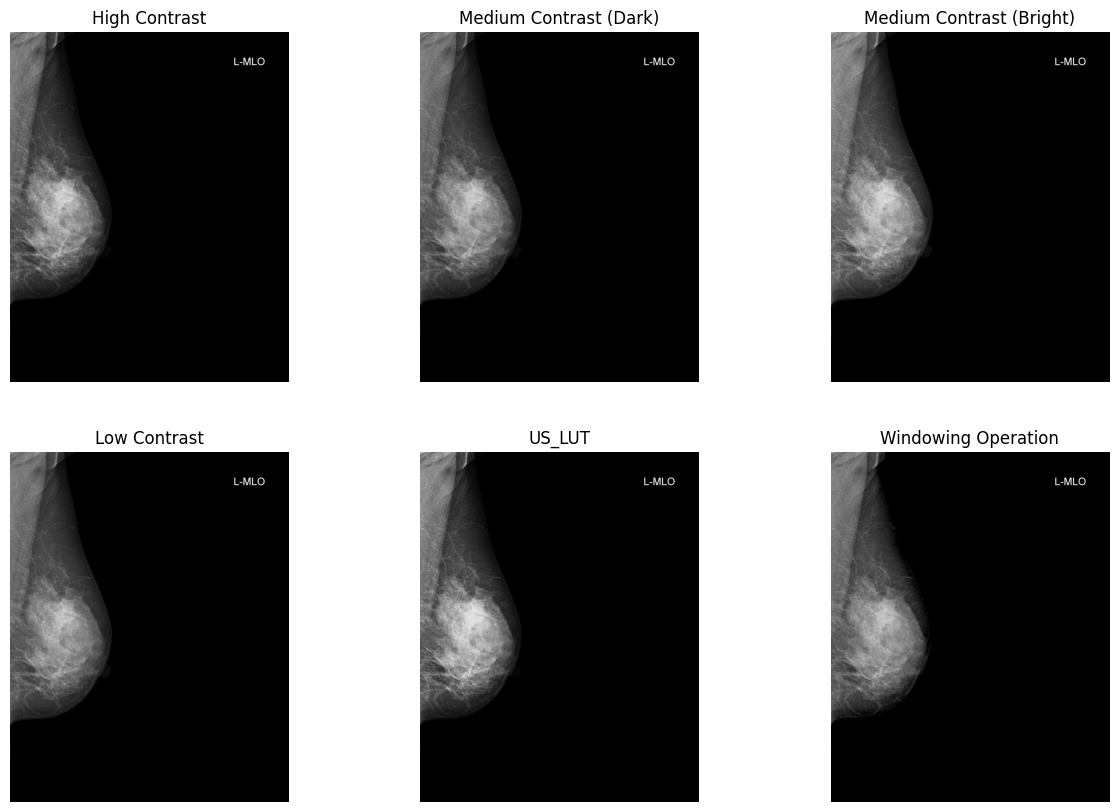

In [6]:

path = utils.get_path('7a6c57ce6034053ca02a8cd32549db7f')
dicom = pydicom.dcmread(path)
voi_lut = dicom[0x0028, 0x3010]
img_arr = dicom.pixel_array
fig, axs = plt.subplots(2, 3,  figsize=(15,10))

for index in range (6):
    i = index // 3
    j = index % 3
    
    if index <= 4:
        img = apply_voi_lut(img_arr, dicom, index)
        axs[i, j].imshow(img, cmap='gray') 
        axs[i, j].axis('off')
        axs[i, j].set_title(voi_lut[index]['LUTExplanation'].value)

    else:    
        img = apply_voi_lut(img_arr, dicom, prefer_lut=False)
        axs[i, j].imshow(img, cmap='gray') 
        axs[i, j].axis('off')
        axs[i, j].set_title('Windowing Operation')

### Revisión de Metadatos Disponibles

In [2]:
findings = utils.findings
all_images_id = findings['image_id'].unique()
all_images_id = pd.DataFrame(data=all_images_id, columns=['image_id'])


try:
    for row in all_images_id.itertuples():
        path = utils.get_path(row[1])
        dicom = pydicom.dcmread(path)
        try:
            voi_lut = dicom[0x0028, 0x3010]
            voi_lut_list = list(voi_lut)
            # Número de valores en el array VOI LUT
            all_images_id.loc[row[0], 'VOI LUT'] = len(voi_lut_list) 
            
            explanations = [explanation[0x0028, 0x3003].value for explanation in voi_lut_list]
            # Lista con la descripción de cada LUT
            all_images_id.loc[row[0], 'LUT Explanation'] = str(explanations)
            
        except KeyError:
            all_images_id.loc[row[0], 'VOI LUT'] = np.nan
            
            
        try: 
            win_explanation = dicom[0x0028, 0x1055].value
            # Descripción de operación Windowing
            all_images_id.loc[row[0], 'Win Explanation'] = str(win_explanation)
        except KeyError:
            all_images_id.loc[row[0], 'Win Explanation'] = np.nan
            
        try:
            Rescale_Intercept = dicom[0x0028, 0x1052].value
            all_images_id.loc[row[0], 'Rescale Intercept'] = Rescale_Intercept
        except KeyError:
            all_images_id.loc[row[0], 'Rescale Intercept'] = np.nan
            
        try:
            Rescale_Slope = dicom[0x0028, 0x1053].value
            all_images_id.loc[row[0], 'Rescale Slope'] = Rescale_Slope
        except KeyError:
            all_images_id.loc[row[0], 'Rescale Slope'] = np.nan
            
        try:
            phi = dicom[0x0028, 0x0004]
            # Valor en Photometric Interpretation
            all_images_id.loc[row[0], 'PhI'] = phi.value
        except KeyError:
            all_images_id.loc[row[0], 'PhI'] = np.nan
except ValueError as e:
    print(f"Error con dicom {row}\n"
          f"{e}")
    

In [3]:
all_images_id

image_id  VOI LUT  \
0      4e3a578fe535ea4f5258d3f7f4419db8      5.0   
1      dac39351b0f3a8c670b7f8dc88029364      5.0   
2      c83f780904f25eacb44e9030f32c66e1      5.0   
3      893528bc38a0362928a89364f1b692fd      5.0   
4      318264c881bf12f2c1efe5f93920cc37      5.0   
...                                 ...      ...   
19995  ea732154d149f619b20070b78060ae65      NaN   
19996  4689616c3d0b46fcba7a771107730791      NaN   
19997  3c22491bcf1d0b004715c28d80981cdd      NaN   
19998  d443b9725e331b8b27589aa725597801      NaN   
19999  45c1239cc36b0e672f0072707fd05c6f      NaN   

                                         LUT Explanation  \
0      ['High Contrast', 'Medium Contrast (Dark)', 'M...   
1      ['High Contrast', 'Medium Contrast (Dark)', 'M...   
2      ['High Contrast', 'Medium Contrast (Dark)', 'M...   
3      ['High Contrast', 'Medium Contrast (Dark)', 'M...   
4      ['High Contrast', 'Medium Contrast (Dark)', 'M...   
...                                                  ...   
19995                                                NaN   
19996                                                NaN   
19997                                                NaN   
19998                                                NaN   
19999                                                NaN   

                                         Win Explanation  Rescale Intercept  \
0                                             linear LUT                0.0   
1                                             linear LUT                0.0   
2                                             linear LUT                0.0   
3                                             linear LUT                0.0   
4                                             linear LUT                0.0   
...                                                  ...                ...   
19995                                        Default W/L                0.0   
19996  ['CURRENT', 'STANDARD', 'CONTRAST', 'SMOOTH', ...                0.0   
19997  ['CURRENT', 'STANDARD', 'CONTRAST', 'SMOOTH', ...                0.0   
19998  ['CURRENT', 'STANDARD', 'CONTRAST', 'SMOOTH', ...                0.0   
19999  ['CURRENT', 'STANDARD', 'CONTRAST', 'SMOOTH', ...                0.0   

       Rescale Slope          PhI  
0                1.0  MONOCHROME2  
1                1.0  MONOCHROME2  
2                1.0  MONOCHROME2  
3                1.0  MONOCHROME2  
4                1.0  MONOCHROME2  
...              ...          ...  
19995            1.0  MONOCHROME1  
19996            1.0  MONOCHROME2  
19997            1.0  MONOCHROME2  
19998            1.0  MONOCHROME2  
19999            1.0  MONOCHROME2  

[20000 rows x 7 columns]

In [4]:
all_images_id.to_csv('images_metadata.csv', index=False)

### Graficar Cantidad de metadatos

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
images_metadata = pd.read_csv('images_metadata.csv')

In [18]:
list(images_metadata.columns[1:])

['VOI LUT',
 'LUT Explanation',
 'Win Explanation',
 'Rescale Intercept',
 'Rescale Slope',
 'PhI']

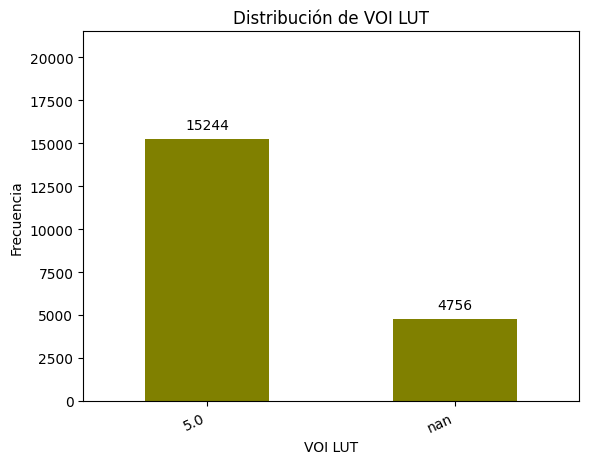

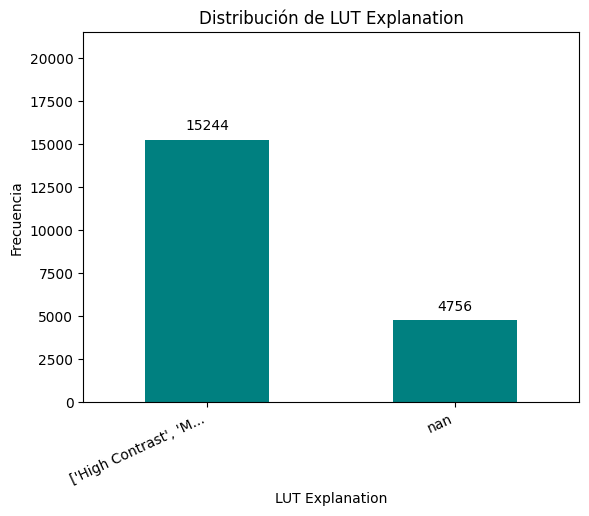

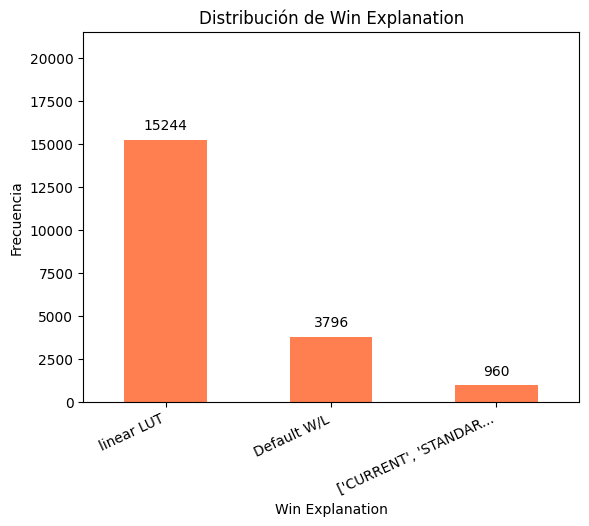

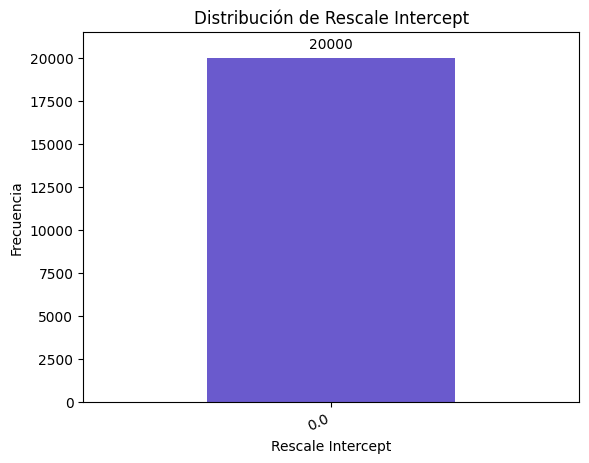

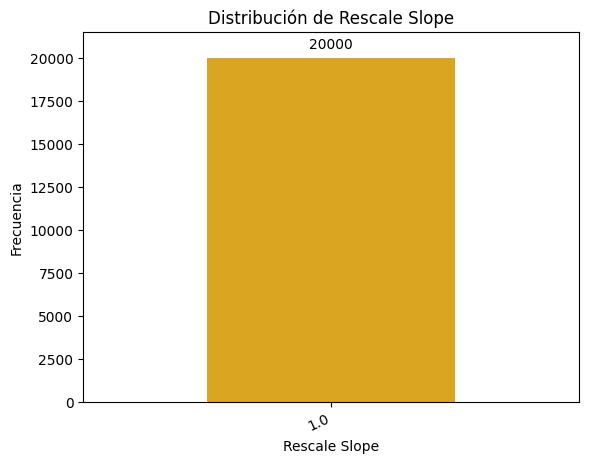

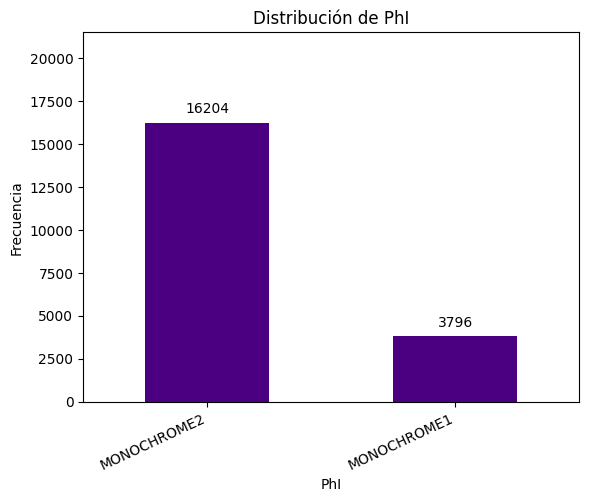

In [31]:
colors = ["olive", "teal", "coral", "slateblue", "goldenrod", "indigo", "tomato"]

def truncate_labels(labels, max_length=20):
    return [label if len(str(label)) <= max_length else str(label)[:max_length] + '...' for label in labels]


for index, item in enumerate(list(images_metadata.columns[1:])):
    
    item_counts = images_metadata[item].value_counts(dropna=False)
    ax = item_counts.plot(kind='bar', color=colors[index])
    
    # Truncar los nombres largos
    truncated_labels = truncate_labels(item_counts.index)
    
    # Cambiar las etiquetas del eje x a las truncadas
    ax.set_xticklabels(truncated_labels, rotation=25, ha='right')
    
    # Agregar los valores numéricos sobre cada barra
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
    ax.set_ylim(0, 21500)
    plt.title(f'Distribución de {item}')
    plt.xlabel(item)
    plt.ylabel('Frecuencia')
    plt.show()

### Revisión Photometric Interpretation 

In [25]:
images_metadata

image_id  VOI LUT  \
0      4e3a578fe535ea4f5258d3f7f4419db8      5.0   
1      dac39351b0f3a8c670b7f8dc88029364      5.0   
2      c83f780904f25eacb44e9030f32c66e1      5.0   
3      893528bc38a0362928a89364f1b692fd      5.0   
4      318264c881bf12f2c1efe5f93920cc37      5.0   
...                                 ...      ...   
19995  ea732154d149f619b20070b78060ae65      NaN   
19996  4689616c3d0b46fcba7a771107730791      NaN   
19997  3c22491bcf1d0b004715c28d80981cdd      NaN   
19998  d443b9725e331b8b27589aa725597801      NaN   
19999  45c1239cc36b0e672f0072707fd05c6f      NaN   

                                         LUT Explanation  \
0      ['High Contrast', 'Medium Contrast (Dark)', 'M...   
1      ['High Contrast', 'Medium Contrast (Dark)', 'M...   
2      ['High Contrast', 'Medium Contrast (Dark)', 'M...   
3      ['High Contrast', 'Medium Contrast (Dark)', 'M...   
4      ['High Contrast', 'Medium Contrast (Dark)', 'M...   
...                                                  ...   
19995                                                NaN   
19996                                                NaN   
19997                                                NaN   
19998                                                NaN   
19999                                                NaN   

                                         Win Explanation  Rescale Intercept  \
0                                             linear LUT                0.0   
1                                             linear LUT                0.0   
2                                             linear LUT                0.0   
3                                             linear LUT                0.0   
4                                             linear LUT                0.0   
...                                                  ...                ...   
19995                                        Default W/L                0.0   
19996  ['CURRENT', 'STANDARD', 'CONTRAST', 'SMOOTH', ...                0.0   
19997  ['CURRENT', 'STANDARD', 'CONTRAST', 'SMOOTH', ...                0.0   
19998  ['CURRENT', 'STANDARD', 'CONTRAST', 'SMOOTH', ...                0.0   
19999  ['CURRENT', 'STANDARD', 'CONTRAST', 'SMOOTH', ...                0.0   

       Rescale Slope          PhI  
0                1.0  MONOCHROME2  
1                1.0  MONOCHROME2  
2                1.0  MONOCHROME2  
3                1.0  MONOCHROME2  
4                1.0  MONOCHROME2  
...              ...          ...  
19995            1.0  MONOCHROME1  
19996            1.0  MONOCHROME2  
19997            1.0  MONOCHROME2  
19998            1.0  MONOCHROME2  
19999            1.0  MONOCHROME2  

[20000 rows x 7 columns]

In [26]:
m_chrome1 = images_metadata.loc[images_metadata['PhI'] == 'MONOCHROME1']

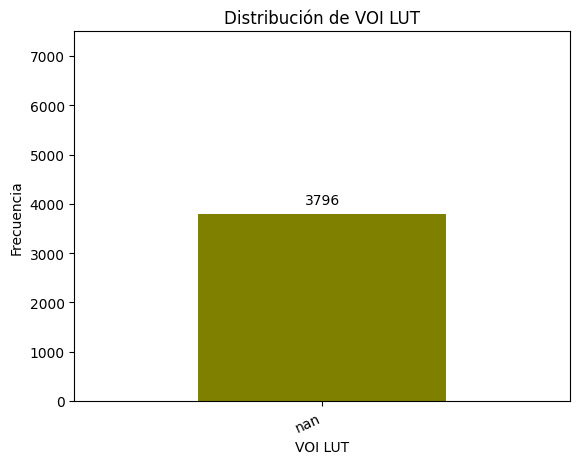

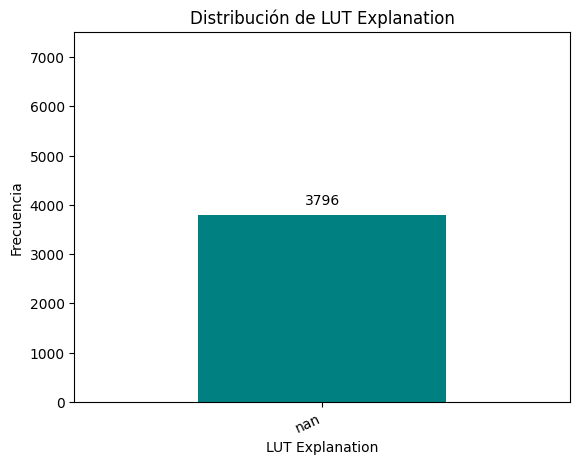

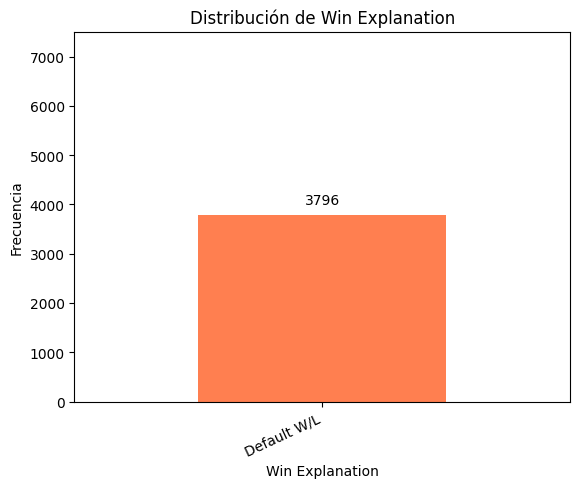

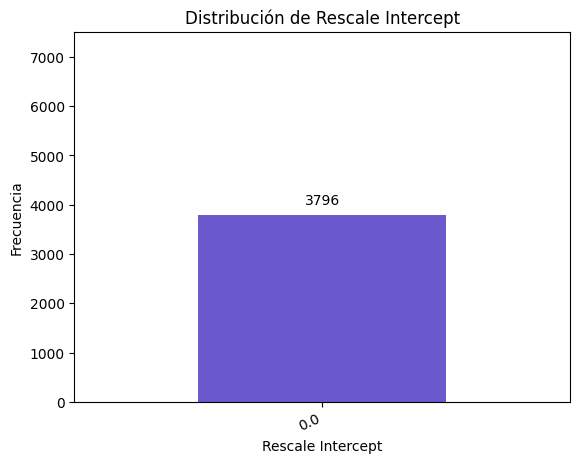

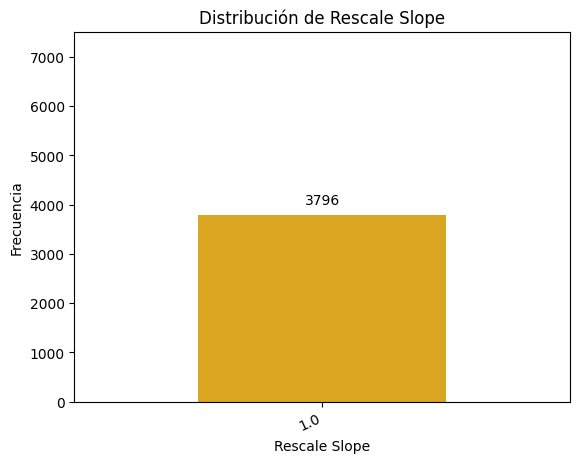

In [34]:
for index, item in enumerate(list(m_chrome1.columns[1:6])):
    
    item_counts = m_chrome1[item].value_counts(dropna=False)
    ax = item_counts.plot(kind='bar', color=colors[index])
    
    # Truncar los nombres largos
    truncated_labels = truncate_labels(item_counts.index)
    
    # Cambiar las etiquetas del eje x a las truncadas
    ax.set_xticklabels(truncated_labels, rotation=25, ha='right')
    
    # Agregar los valores numéricos sobre cada barra
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
    ax.set_ylim(0, 7500)
    plt.title(f'Distribución de {item}')
    plt.xlabel(item)
    plt.ylabel('Frecuencia')
    plt.show()

In [29]:
m_chrome2 = images_metadata.loc[images_metadata['PhI'] == 'MONOCHROME2']

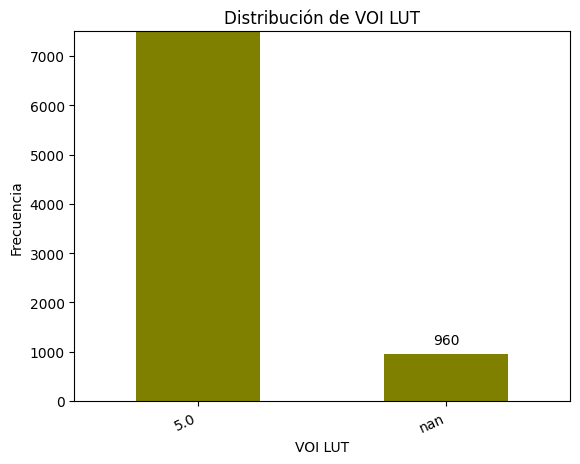

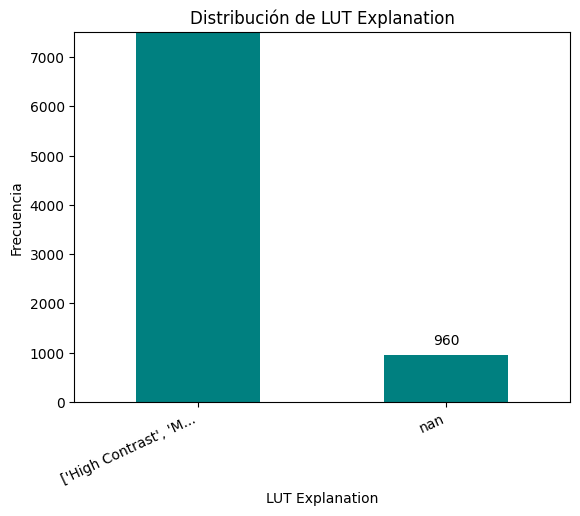

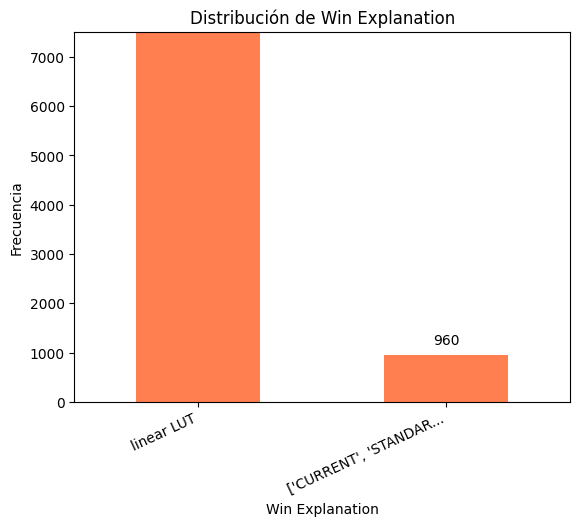

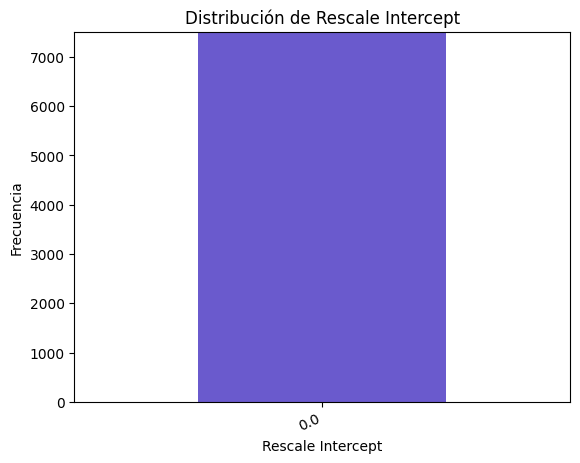

In [33]:
for index, item in enumerate(list(m_chrome2.columns[1:5])):
    
    item_counts = m_chrome2[item].value_counts(dropna=False)
    ax = item_counts.plot(kind='bar', color=colors[index])
    
    # Truncar los nombres largos
    truncated_labels = truncate_labels(item_counts.index)
    
    # Cambiar las etiquetas del eje x a las truncadas
    ax.set_xticklabels(truncated_labels, rotation=25, ha='right')
    
    # Agregar los valores numéricos sobre cada barra
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
    ax.set_ylim(0, 7500)
    plt.title(f'Distribución de {item}')
    plt.xlabel(item)
    plt.ylabel('Frecuencia')
    plt.show()

### Conclusiones

Se encuentran 3 grupos de imágenes:

- 3.796 - Monochrome1, No posee valores VOI LUT, pero si de Windowing (Default W/L)
    
- 960 - Monochrome2, No posee valores de VOI LUT, pero si de Windowing (['CURRENT', 'STANDARD', 'CONTRAST', 'SMOOTH', 'CUSTOM'])
- 15.244 - Monochrome2, Posee valores de VOI LUT (['High Contrast', 'Medium Contrast (Dark)', 'Medium Contrast (Bright)', 'Low Contrast', 'US_LUT']) y de Windowing (linear LUT)

#### Comprobación

In [52]:
len(images_metadata.loc[
        (images_metadata['Win Explanation'] == "Default W/L") & 
        (images_metadata['LUT Explanation'].isna()) & 
        (images_metadata['PhI'] == 'MONOCHROME1')])

3796

In [51]:
len(images_metadata.loc[
        (images_metadata['Win Explanation'] == "['CURRENT', 'STANDARD', 'CONTRAST', 'SMOOTH', 'CUSTOM']") &
        (images_metadata['LUT Explanation'].isna()) & 
        (images_metadata['PhI'] == 'MONOCHROME2')
    ])

960

In [41]:
len(images_metadata.loc[
        (images_metadata['Win Explanation'] == 'linear LUT') & 
        (images_metadata['LUT Explanation'] == "['High Contrast', 'Medium Contrast (Dark)', 'Medium Contrast (Bright)', 'Low Contrast', 'US_LUT']") & 
        (images_metadata['PhI'] == 'MONOCHROME2')
    ])

15244